# 關鍵字資料整理

## 讀入套件跟函數

In [1]:
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

import spacy
from itertools import combinations


# Set globals
nlp = spacy.load("en_core_web_md")

def pre_process(titles):
    """
    Pre-processes titles by removing stopwords and lemmatizing text.
    :param titles: list of strings, contains target titles,.
    :return: preprocessed_title_docs, list containing pre-processed titles.
    """

    # Preprocess all the titles
    title_docs = [nlp(x) for x in titles]
    preprocessed_title_docs = []
    lemmatized_tokens = []
    for title_doc in title_docs:
        for token in title_doc:
            if not token.is_stop:
                lemmatized_tokens.append(token.lemma_)
        preprocessed_title_docs.append(" ".join(lemmatized_tokens))
        del lemmatized_tokens[
            :
            ]  # empty the lemmatized tokens list as the code moves onto a new title

    return preprocessed_title_docs

def similarity_filter(titles):
    """
    Recursively check if titles pass a similarity filter.
    :param titles: list of strings, contains titles.
    If the function finds titles that fail the similarity test, the above param will be the function output.
    :return: this method upon itself unless there are no similar titles; in that case the feed that was passed
    in is returned.
    """

    # Preprocess titles
    preprocessed_title_docs = pre_process(titles)

    # Remove similar titles
    all_summary_pairs = list(combinations(preprocessed_title_docs, 2))
    similar_titles = []
    for pair in all_summary_pairs:
        title1 = nlp(pair[0])
        title2 = nlp(pair[1])
        similarity = title1.similarity(title2)
        if similarity > 0.8:
            similar_titles.append(pair)

    titles_to_remove = []
    for a_title in similar_titles:
        # Get the index of the first title in the pair
        index_for_removal = preprocessed_title_docs.index(a_title[0])
        titles_to_remove.append(index_for_removal)

    # Get indices of similar titles and remove them
    similar_title_counts = set(titles_to_remove)
    similar_titles = [
        x[1] for x in enumerate(titles) if x[0] in similar_title_counts
    ]

    # Exit the recursion if there are no longer any similar titles
    if len(similar_title_counts) == 0:
        return titles

    # Continue the recursion if there are still titles to remove
    else:
        # Remove similar titles from the next input
        for title in similar_titles:
            idx = titles.index(title)
            titles.pop(idx)
            
        return similarity_filter(titles)

In [2]:
## selenium package
while True:
    from selenium import webdriver
    from selenium.common.exceptions import NoSuchElementException
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.support.ui import WebDriverWait as wait
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support import expected_conditions as EC
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.common.action_chains import ActionChains #move_to_element
    from selenium.common.exceptions import StaleElementReferenceException #error > element is not attached to the page document
    from selenium.common.exceptions import NoSuchElementException #點完所有按鈕時
    from selenium.webdriver.common.keys import Keys
    break

## text mining package
while True:
    import nltk
    from nltk.probability import FreqDist
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.tokenize import sent_tokenize, word_tokenize ,RegexpTokenizer
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    import string 
    from rake_nltk import Rake
    from rake_nltk import Metric, Rake
    import fuzzywuzzy
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import spacy
    import pytextrank
    from summa import keywords
    from textrank4zh import TextRank4Keyword, TextRank4Sentence
    from nltk import FreqDist
    #import enchant
    break

## other package
while True:
    import time 
    from bs4 import BeautifulSoup
    from pprint import pprint
    import requests
    import csv
    from pandas import Series,DataFrame
    import unicodecsv
    import pandas as pd
    import numpy as np
    import re

    import os 
    os.chdir("D:\\D槽的東西\\桌面\\KKDay\\爬蟲\\資料儲存")
    # save env
    import pickle  
    # get geocoding 
    from geopy.geocoders import GoogleV3
    import geopy
    from datetime import datetime
    from datetime import date
    from datetime import timedelta
    import json

    from termcolor import colored
    from datetime import datetime
    from datetime import date
    from datetime import timedelta
    from IPython.display import display
    from collections import OrderedDict
    import pandasql as ps

    break
    
while True:
    def scrolling_func(x,scroll_time,last_height):
        while x:
            # scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # wait to load page
            time.sleep(scroll_time)
            # calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

    def tourist_web_open_func(url):
        s=Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.maximize_window()
        driver.get(url)
        wait(driver,10)
        soup = BeautifulSoup(driver.page_source,'lxml')
        driver.close()
        return  soup

    def get_la_lon_func(address):
        s=Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=s)
        driver.maximize_window()
        url = 'https://www.latlong.net/'
        driver.get(url)
        wait(driver,10)
        #driver.execute_script("document.getElementById("+results+").click()")
        driver.find_element_by_id('place').send_keys(address)
        driver.find_element_by_id('btnfind').click()
        wait(driver,10)
        soup = BeautifulSoup(driver.page_source,'lxml')
        driver.delete_all_cookies()
        driver.close()
        return  soup

    def web_open_and_scroll_func(url):
        s=Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.maximize_window()
        driver.get(url)
        wait(driver,10)

        ## scroll web to get information (https://ppt.cc/fqHTcx)
        scroll_time  = 0.5
        # get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")
        #start scroll 
        while True:
            # scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # wait to load page
            time.sleep(scroll_time)
            # calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        wait(driver,10)
        soup = BeautifulSoup(driver.page_source,'lxml')
        driver.close()
        
        return  soup

    def web_open(x,url):
        # 啟動瀏覽器工具的選項
        options = webdriver.ChromeOptions()
        if x=='not open':
            options.add_argument("--headless")              #不開啟實體瀏覽器背景執行
        else:
            pass
        options.add_argument("--start-maximized")         #最大化視窗
        options.add_argument("--incognito")               #開啟無痕模式
        options.add_argument("--disable-popup-blocking ") #禁用彈出攔截
        options.add_experimental_option('prefs', {'intl.accept_languages': 'en,en_US'})#語言換成英文
        #s=Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(ChromeDriverManager().install(),options = options)
        driver.maximize_window()

        # Step 2) Navigate to Facebook
        driver.get(url)
        driver.implicitly_wait(15)
        return driver

    def artical_content_and_lan_lon(url):
        driver.get(url)
        content = (driver.find_element_by_css_selector('#__next > div > div.css-i9gxme > div > div.css-xiirv3').text).replace("\n", "")
        lan_lon = (driver.find_element_by_css_selector('#__next > div > div.css-i9gxme > div > div.css-xiirv3 > ul > li:nth-child(1) > a')).get_attribute("href")
        lan,lon = str(lan_lon).partition('query=')[2].split(",")
        return content,lan,lon
    break

C:\Users\User\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### (1)讀入新加坡資料

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [76]:
## open singapore attraction from google travel 
with open('google_singapore_attraction.pickle','rb') as handle:
    google_singapore_attraction= pickle.load(handle)
    
#convert object to string 
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].astype(pd.StringDtype())
#check dataframe variable type 
google_singapore_attraction.dtypes
#replace attraction_reviews  punctuation  to none
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_singapore_attraction['latitude'] = pd.to_numeric(google_singapore_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['longtitude'] = pd.to_numeric(google_singapore_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_singapore_attraction['latitude'] = google_singapore_attraction['latitude'].astype(float)
google_singapore_attraction['longtitude'] = google_singapore_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']<1.1] =None
google_singapore_attraction['latitude'].loc[google_singapore_attraction['latitude']>=1.5] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']<103] =None
google_singapore_attraction['longtitude'].loc[google_singapore_attraction['longtitude']>=105] =None
where_is_empty  = np.where(pd.isnull(google_singapore_attraction['longtitude']))
lat_long = pd.read_csv('lat_lon.csv')
for i in where_is_empty:
    google_singapore_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_singapore_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]

## open singapore attraction from Visit_Singapore
with open('Singapore_Attraction_info.pickle','rb') as handle:
    Singapore_Attraction_info= pickle.load(handle)
Singapore_Attraction_info['latitude'] = Singapore_Attraction_info['latitude'].astype(float)
Singapore_Attraction_info['longitude'] = Singapore_Attraction_info['longitude'].astype(float)
#replace irrational value of latitude and longitude 
Singapore_Attraction_info['latitude'].loc[Singapore_Attraction_info['latitude']<1.2] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']<103] =None
Singapore_Attraction_info['longitude'].loc[Singapore_Attraction_info['longitude']>=104] =None
Singapore_Attraction_info = Singapore_Attraction_info.drop_duplicates('Name')
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[60])
Singapore_Attraction_info = Singapore_Attraction_info.drop(Singapore_Attraction_info.index[99])
Singapore_Attraction_info = Singapore_Attraction_info.reset_index()
## open singapore festival and events from Visit_Singapore
with open('singapore_festival_and_events.pickle','rb') as handle:
    singapore_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('Singapore_facebook_all_done_20210721.pickle','rb') as handle:
    Singapore_facebook= pickle.load(handle)

## open singapore Instagram post
with open('Singapore_Intstagram.pickle','rb') as handle:
    Singapore_Intstagram= pickle.load(handle)

## open singapore google trend result 
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore= pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

<ipython-input-76-47316c75fa40>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-76-47316c75fa40>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_singapore_attraction['attraction_reviews'] = google_singapore_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

### (2)新加坡 - 景點描述

In [77]:
## textrank to get keyword 
keyword = []
Singapore_Attraction_info['Keyword'] = 0
Singapore_Attraction_info['Keyword'].astype(object)
for j in range(Singapore_Attraction_info.shape[0]):
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    #temp  = Singapore_Attraction_info['Name'].iloc[j] +" "+Singapore_Attraction_info['Description'].iloc[j] 
    temp  = Singapore_Attraction_info['Description'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =10, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    Singapore_Attraction_info['Keyword'].iloc[j] = stemmed_words
    #print(stemmed_words)
keyword= list(dict.fromkeys(keyword))

## stop_words
#  https://ppt.cc/f8gXAx
#download stopwords from  nltk library
nltk.download('stopwords')
#get stop words from specific languge
stop_words=set(stopwords.words("english"))
#add stop words
stop_words.update(['never run', 'super', 'stylish','natural', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles','things', 'also known','thing', 'feat', 'become', 'restored', 'fantastic form', 'broken','singapore ’','make','lose','forget', 'west', '’', 'many trails', 'experience singapore', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'singapore'])
#turn to set
stop_words = set(stop_words)
#get rid of stop words 
Singapore_Attraction_info['Keyword'] = Singapore_Attraction_info['Keyword'].apply(lambda x: [item for item in x if item not in stop_words])

#https://ppt.cc/fIFMfx
use_text_list = [] 
for i in range(Singapore_Attraction_info.shape[0]):
    text_list = Singapore_Attraction_info['Keyword'].iloc[i]
    str_text = ' '.join(str(e) for e in text_list)
    use_text_list.append(str_text)
use_text_list_1 = ' '.join(str(e) for e in use_text_list)
tokens = nltk.word_tokenize(use_text_list_1)
fdist=FreqDist(tokens)
###  tag list to dataframe  ### 
#list(filter(lambda x: x[1]>2,fdist.items()))[0][0]
drop_list = ["neighbourhood","explore","home","district","fun","attraction","city","bustle","rich","lover","discover","destination","world","view","design","part","house","time","story","large","experience","stretch"]
tag_list = []
for i in range(len(list(filter(lambda x: x[1]>2  ,fdist.items())))):
    tag_list.append(list(filter(lambda x: x[1]>2 ,fdist.items()))[i][0])
tag_list = [tag for tag in tag_list if tag not in drop_list]
convert_tag_list = ['museum','art','heritage','centre','civic','beach','culture','history','architecture','river','vibrant','shop','history','eatery','history','culture','community','chinatown','temple','bay','modern','class','peranakan','architecture','garden','landmark','mosque','nature','national','japanese','occupation','war','memorial','esplanade','park','old','asian','exhibition','contemporary','music','chinese','artefact','resort','sentosa','diverse']
tag = pd.DataFrame(list(zip(tag_list,convert_tag_list)),columns =['Name', 'tag'])

for i in range(Singapore_Attraction_info.shape[0]):
    temp_keyword_textrank = [] 
    for j in range(len(Singapore_Attraction_info['Keyword'].iloc[i])):
        for k in range(tag.shape[0]):
            if Singapore_Attraction_info['Keyword'].iloc[i][j]  == tag['Name'].iloc[k]:
                temp_keyword_textrank.append(tag['tag'].iloc[k])
            else:
                pass
    Singapore_Attraction_info['Keyword'].iloc[i] = list(set(temp_keyword_textrank))
#tag_list = pd.DataFrame(list(zip(tag_list)),columns =['Name'])
#tag_list.to_csv('text_rank1.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
##### textrank to get keyword ( find empty  list to replace ) #####
###  find empty  list to replace  ###
empty_list = Singapore_Attraction_info.index[Singapore_Attraction_info['Keyword'].apply(lambda x: x==[])]

keyword = []
for j in empty_list:
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    temp  = Singapore_Attraction_info['Name'].iloc[j] +" "+Singapore_Attraction_info['Description'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =5, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    drop_list = ['buloh','kingfisher','wetland','otter','reserve','explore','fly','large', 'sound', 'unfold', 'light', 'captivate','minute', 'singapore', 'family', 'place', 'facility', 'glorious', 'reawaken', 'refinement', 'elegant','wave', 'creative', 'twist', 'break', 'fantastic','duxton', 'fear', 'forget', 'view', 'majestic', 'physical', 'story', 'tell','city', 'hall','sun', 'yat', 'sen', 'city', 'clear', 'giant','fly' 'large', 'collection', 'hold', 'close','stripe','air', 'open','beneath', 'realm', 'world','fab', 'car', 'cable', 'din', 'entertainment', 'bustle', 'tranquil', 'respite', 'patch']
    stemmed_words = [tag for tag in stemmed_words if tag not in drop_list]
    Singapore_Attraction_info['Keyword'].iloc[j] = stemmed_words
keyword= list(dict.fromkeys(keyword))

Singapore_Attraction_info['Keyword'].iloc[17]=['hotel']
Singapore_Attraction_info['Keyword'].iloc[20]=['bridge']
Singapore_Attraction_info['Keyword'].iloc[22]=['building']
Singapore_Attraction_info['Keyword'].iloc[40]=['museum']
Singapore_Attraction_info['Keyword'].iloc[84]=['giant observation','wheel']
Singapore_Attraction_info['Keyword'].iloc[99]=["national park","natural reverse"]
Singapore_Attraction_info['Keyword'].iloc[103]=['park']
#Singapore_Attraction_info.loc[empty_list,['Name','Description']].to_csv('text_rank.csv')


########  clean data  ########
'''
column_count = max(Singapore_Attraction_info['Keyword'].str.len())
Singapore_Attraction_info['Keyword'] = Singapore_Attraction_info['Keyword'].astype(pd.StringDtype())
temp = Singapore_Attraction_info['Keyword'].str.split(',', expand=True)
for i in range(column_count):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    Singapore_Attraction_info['keyword_{}'.format(i+1)] =temp[i]


#get usable columns
Singapore_Attraction_info = pd.DataFrame(Singapore_Attraction_info.loc[:,["Type","Name","Description","Link","Address","latitude","longitude","pic_link","Keyword",
                                                                          "keyword_1","keyword_2","keyword_3","keyword_4","keyword_5","keyword_6"]])
#rename columns
Singapore_Attraction_info.columns =['attraction_bureau_type', 'attraction_bureau_name', 'attraction_bureau_descriptions', 
                                    'attraction_bureau_link', 'attraction_bureau_address','bureau_latitude', 'bureau_longitude', 
                                    'attraction_bureau_pic_link','keyword_bureau','keyword_1_bureau','keyword_2_bureau','keyword_3_bureau',
                                    'keyword_4_bureau','keyword_5_bureau','keyword_6_bureau']
'''
#get usable columns
Singapore_Attraction_info = pd.DataFrame(Singapore_Attraction_info.loc[:,["Type","Name","Description","Link","Address","latitude","longitude","pic_link","Keyword"]])
#rename columns
Singapore_Attraction_info.columns =['attraction_type_bureau', 'attraction_name_bureau', 'attraction_descriptions_bureau', 
                                    'attraction_link_bureau', 'attraction_address_bureau','latitude_bureau', 'longitude_bureau', 
                                    'attraction_pic_link_bureau','keyword_bureau']
#give source
Singapore_Attraction_info['source_bureau'] = "Tourism bureau"


#store data
with open('Singapore_Attraction_info_keyword.pickle', 'wb') as handle:
    pickle.dump(Singapore_Attraction_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#############################   沒有用到的部分   ############################# 
##用rake_nltk得到keyword
#n_gram最小為1，最大為2。有用degreee to frequency去抓出排名
rake_nltk_var = Rake(min_length=1, max_length=2,ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
Singapore_Attraction_info['keyword']=0
Singapore_Attraction_info['keyword'].astype(object)

for i in range(Singapore_Attraction_info.shape[0]):
    #抓出keyword
    rake_nltk_var.extract_keywords_from_text(Singapore_Attraction_info['Description'].iloc[i])
    #得到排名前五大
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[0:4]
    #將得到的keyword加入到原本的資料集中
    Singapore_Attraction_info['keyword'].iloc[i]  = np.array(keyword_extracted, dtype=object)
    #print(keyword_extracted)

#turn word to  lower
Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].apply(lambda x: [item.lower() for item in x if item])
## stop_words
#  https://ppt.cc/f8gXAx
#download stopwords from  nltk library
nltk.download('stopwords')
#get stop words from specific languge
stop_words=set(stopwords.words("english"))
#add stop words
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles','things', 'also known','thing', 'feat', 'become', 'restored', 'fantastic form', 'broken','singapore ’','make','lose','forget', 'west', '’', 'many trails', 'experience singapore', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'singapore'])
#turn to set
stop_words = set(stop_words)
#get rid of stop words 
Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].apply(lambda x: [item for item in x if item not in stop_words])

## punctuation
#  https://ppt.cc/f8gXAx
nltk.download('punkt')
tokenizer = RegexpTokenizer(r'\w+')
#get rid of punctuation (using string package)
Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].apply(lambda x: [item for item in x if item not in string.punctuation])

'''
for i in range(Singapore_Attraction_info.shape[0]):
    print(Singapore_Attraction_info['keyword'].iloc[i])
'''

# Lemmatizer
nltk.download('wordnet')
for i in range(Singapore_Attraction_info['keyword'].shape[0]):
    lem = WordNetLemmatizer()
    stemmed_words=[]
    for j in range(len(Singapore_Attraction_info['keyword'].iloc[i])):
        stemmed_words.append(lem.lemmatize((Singapore_Attraction_info['keyword'].iloc[i])[j],"v"))
    Singapore_Attraction_info['keyword'].iloc[i] = stemmed_words
#get rid of stop words 
Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].apply(lambda x: [item for item in x if item not in stop_words])
#get rid of stop words 
Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].apply(lambda x: [item+= ' '+item for item in x])




Singapore_Attraction_info['keyword'] = Singapore_Attraction_info['keyword'].astype(pd.StringDtype())
temp = Singapore_Attraction_info['keyword'].str.split(',', expand=True)
for i in range(3):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    Singapore_Attraction_info['keyword_{}'.format(i+1)] =temp[i]

#get usable columns
Singapore_Attraction_info = pd.DataFrame(Singapore_Attraction_info.loc[:,["Type","Name","Description","Link","Address","latitude","longitude","pic_link","keyword","keyword_1","keyword_2","keyword_3"]])
#rename columns
Singapore_Attraction_info.columns =['attraction_bureau_type', 'attraction_bureau_name', 'attraction_bureau_descriptions', 'attraction_bureau_link', 'attraction_bureau_address','bureau_latitude', 'bureau_longitude', 'attraction_bureau_pic_link','keyword_bureau','keyword_1_bureau','keyword_2_bureau','keyword_3_bureau']
#give source
Singapore_Attraction_info['bureau_source'] = "Tourism bureau"
#display dataframe
Singapore_Attraction_info.head(10)

with open('Singapore_Attraction_info_keyword.pickle', 'wb') as handle:
    pickle.dump(Singapore_Attraction_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
#Singapore_Attraction_info.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\Singapore_Attraction_info_keyword.txt', index=False)


In [58]:
t = Singapore_Attraction_info['Keyword_textrank']
Singapore_Attraction_info.index[Singapore_Attraction_info['Keyword_textrank'].apply(lambda x: x==[])]

Int64Index([0, 15, 17, 20, 22, 36, 40, 84, 85, 90, 91, 94, 95, 99, 103, 107], dtype='int64')

### (3)新加坡 - 節慶描述

In [40]:
rake_nltk_var = Rake(min_length=1, max_length=2,ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
singapore_festival_and_events['keyword']=0
singapore_festival_and_events['keyword'].astype(object)

for i in range(singapore_festival_and_events.shape[0]):
    rake_nltk_var.extract_keywords_from_text(singapore_festival_and_events['Description'].iloc[i])
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[0:4]
    singapore_festival_and_events['keyword'].iloc[i]  = np.array(keyword_extracted, dtype=object)
    #print(keyword_extracted)

#  word lower
singapore_festival_and_events['keyword'] = singapore_festival_and_events['keyword'].apply(lambda x: [item.lower() for item in x if item])


#  stop_words
#  https://ppt.cc/f8gXAx
nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
#stop_words = nltk.corpus.stopwords.words('english')
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','singapore ’','make','lose','forget', 'west', '’', 'many trails', 'experience singapore', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'singapore'])
stop_words = set(stop_words)
singapore_festival_and_events['keyword'] = singapore_festival_and_events['keyword'].apply(lambda x: [item for item in x if item not in stop_words])

#  get rid of punctuation (using string package)
#  https://ppt.cc/f8gXAx
tokenizer = RegexpTokenizer(r'\w+')
singapore_festival_and_events['keyword'] = singapore_festival_and_events['keyword'].apply(lambda x: [item for item in x if item not in string.punctuation])
#display(singapore_festival_and_events['keyword'])

for i in range(singapore_festival_and_events.shape[0]):
    print(singapore_festival_and_events['keyword'].iloc[i])

['singapore remember', 'sacrifice', 'reflection']
['singapore roars', 'national day', 'colourful rise', 'remembers']
['fine cuisine', 'excellent wines', 'head']
['dusk falls', 'streets', 'art']
['culinary insights', 'centre stage']
['rich traditions', 'chinese population', 'memories']
['singapore celebrates', 'family gatherings', 'autumn harvest', 'autumn festival']
['taste buds', 'intoxicating adventure', 'artisanal concoctions', 'display']
['world ’', 'well', 'pitch']
['tantalising aromas', 'little india', 'bright colours', 'streets']
['uses virtual', 'fuse fitness', 'shaping']
['yuletide spirits', 'year round', 'full swing', 'christmas extravaganza']
['orchard road', 'joyous festivities', 'holiday spirit', 'soak']
['get snow', 'year', 'reindeers']
['singapore brings', 'new year', 'bustling vibes', 'bright lights']
['toy story', 'galaxy far', 'favourite toys', 'far away']
['colourful intimations', 'age gone', 'pongal', 'charms']
['walking tours', 'annual treat', 'lovers', 'inspire']


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### (4)新加坡 - google travel

In [79]:
## textrank to get keyword 
keyword = []
google_singapore_attraction['Keyword'] = 0
google_singapore_attraction['Keyword'].astype(object)
for j in range(google_singapore_attraction.shape[0]):
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    #temp  = google_singapore_attraction['attraction_name'].iloc[j] +" "+google_singapore_attraction['attraction_descriptions'].iloc[j] 
    temp  = google_singapore_attraction['attraction_descriptions'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =10, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    google_singapore_attraction['Keyword'].iloc[j] = stemmed_words
    #print(stemmed_words)
keyword= list(dict.fromkeys(keyword))

## stop_words
#  https://ppt.cc/f8gXAx
#download stopwords from  nltk library
nltk.download('stopwords')
#get stop words from specific languge
stop_words=set(stopwords.words("english"))
#add stop words
stop_words.update(['never run', 'super', 'stylish','natural', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles','things', 'also known','thing', 'feat', 'become', 'restored', 'fantastic form', 'broken','singapore ’','make','lose','forget', 'west', '’', 'many trails', 'experience singapore', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'singapore'])
#turn to set
stop_words = set(stop_words)
#get rid of stop words 
google_singapore_attraction['Keyword'] = google_singapore_attraction['Keyword'].apply(lambda x: [item for item in x if item not in stop_words])

#https://ppt.cc/fIFMfx
use_text_list = [] 
for i in range(google_singapore_attraction.shape[0]):
    text_list = google_singapore_attraction['Keyword'].iloc[i]
    str_text = ' '.join(str(e) for e in text_list)
    use_text_list.append(str_text)
use_text_list_1 = ' '.join(str(e) for e in use_text_list)
tokens = nltk.word_tokenize(use_text_list_1)
fdist=FreqDist(tokens)
###  tag list to dataframe  ### 
#list(filter(lambda x: x[1]>2,fdist.items()))[0][0]

## unecessary words
drop_list = ["public","land","sky","tiger","palawan","tv","theme","movie","found","tall","acre","set","open","shape","fish","lion","leisure",
            "complex","preserve","bird","diversity","guide","tour","hall","diverse","din","chic","upscale","jawa","gong","bo","da","chek","site","event",
            "event","freshwater","dna","strip","car","expansive","artfully","depict","scenic","enormous","plant","educational","play","luge","wind","pave",
            "track","floor","ornate","notable","vibrant","spot","vertical","tree","slide","big","water","zip","recreational","line","optical","bird","event",
            "optical","sprawl","dig","turtle","rare","thousand","display","level","multi","trip","day","lush","style","space","luxury","sizable","retailer",
            "pedestrian","live","bbq","bike","sandy","area","war","ii","simulate","indoor","detail","suspension","tranquil","calm","kid","class","colorful","game",
            "slot","table","aerial","supertrees","spacious","singaporean","era","perform","indie","plaza","hip","tiong","venerable","decor","visitor","inter","early",
            "airy","regional","stall","fresh","produce","clothe","giant","iconic","performance","toy","childhood","huge","organic","hike","neighbourhood","explore",
            "home","district","fun","attraction","city","bustle","rich","lover","discover","destination","world","view","design","part","house","time","story","large",
            "experience","stretch","reclaim"]
#tag_list = []
#for i in range(len(list(filter(lambda x: x[1]>2  ,fdist.items())))):
    #tag_list.append(list(filter(lambda x: x[1]>2 ,fdist.items()))[i][0])

##create tag list 
tag_list = []
for i in range(len(list(fdist.items()))):
    tag_list.append((list(fdist.items())[i][0]))
## delete unecessary words
tag_list = [tag for tag in tag_list if tag not in drop_list]
## transform to words
convert_tag_list = ["garden","modern","beach","tower","amusement","park","botanical","gaint observation","wheel","zoo","rainforest","nocturnal",
                    "animal","technology","flower","museum","chinese","baroque","shop","statue","fountain","riverside","landmark","culture","art",
                    "history","asian","building","natural reverse","wildlife","aquarium","dive","concert","studio","theater","bay","resort","hotel",
                    "spa","wetland","temple","hilltop","history","buddha","relic","airport","nature","mall","boat","model","footbridge","structure",
                    "exhibit","activity","creature","aquatic","marine","history","lake","trail","greenhouse","exotic","reserve","mosque","sustainability",
                    "reservoir","interactive","chairlift","school","contemporary","path","deck","hindu","century","feature","wax","american","tropical",
                    "bar","eatery","convent","illusion","habitat","shrine","orchid","rooftop","venue","island","victorian","food","restore","market","neoclassical",
                    "peranakan","waterside","architecture","bridge","gallery","music","coastal","fort","skydive","tunnel","center","classic","coral","reef",
                    "canalside","landscape","pond","nighttime","show","machine","artifact","wwii","indian","diaspora","walkway","chinatown","shop","military",
                    "bunker","cinema","visual","bahru","boutique","national","tidal","centre","gothic","sanctuary","hawker","music","vintage","memorabilia","library",
                    "farm","bistro","mountain"]
## list to dataframe
tag = pd.DataFrame(list(zip(tag_list,convert_tag_list)),columns =['Name', 'tag'])
## for loop to give tag
for i in range(google_singapore_attraction.shape[0]):
    temp_keyword_textrank = [] 
    for j in range(len(google_singapore_attraction['Keyword'].iloc[i])):
        for k in range(tag.shape[0]):
            if google_singapore_attraction['Keyword'].iloc[i][j]  == tag['Name'].iloc[k]:
                temp_keyword_textrank.append(tag['tag'].iloc[k])
            else:
                pass
    google_singapore_attraction['Keyword'].iloc[i] = list(set(temp_keyword_textrank))



##### textrank to get keyword ( find empty  list to replace ) #####
###  find empty  list to replace  ###
empty_list = google_singapore_attraction.index[google_singapore_attraction['Keyword'].apply(lambda x: x==[])]
##find attraction's name that has empty keyword
google_singapore_attraction['attraction_name'].iloc[empty_list]
google_singapore_attraction['Keyword'].iloc[empty_list] = 'cable car'


########  clean data  ########
'''
column_count = max(google_singapore_attraction['Keyword'].str.len())
google_singapore_attraction['Keyword'] = google_singapore_attraction['Keyword'].astype(pd.StringDtype())
temp = google_singapore_attraction['Keyword'].str.split(',', expand=True)
for i in range(column_count):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    google_singapore_attraction['keyword_{}'.format(i+1)] =temp[i]


#rename columns
google_singapore_attraction.columns =["attraction_google_travel_name","attraction_stars_google_travel","attraction_reviews_google_travel",
                                      "attraction_descriptions_google_travel","attraction_pic_link_google_travel","latitude_google_travel",
                                      "longtitude_google_travel","keyword",'keyword_1_google_travel','keyword_2_google_travel','keyword_3_google_travel',
                                      'keyword_4_google_travel','keyword_5_google_travel']
'''
#rename columns
google_singapore_attraction.columns =["attraction_name_google_travel","attraction_stars_google_travel","attraction_reviews_google_travel",
                                      "attraction_descriptions_google_travel","attraction_pic_link_google_travel","latitude_google_travel",
                                      "longitude_google_travel","keyword_google_travel"]
#give source
google_singapore_attraction['source_google_travel'] = "Google Travel"


with open('google_singapore_attraction_keyword.pickle', 'wb') as handle:
    pickle.dump(google_singapore_attraction, handle, protocol=pickle.HIGHEST_PROTOCOL)
#google_singapore_attraction.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_singapore_attraction_keyword.txt', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
google_singapore_attraction

,attraction_google_travel_name,attraction_stars_google_travel,attraction_reviews_google_travel,attraction_descriptions_google_travel,attraction_pic_link_google_travel,latitude_google_travel,longtitude_google_travel,keyword,google_travel_source
0,Gardens by the Bay,4.7,"108,216",Modern public gardens on reclaimed land,https://encrypted-tbn0.gstatic.com/images?q=tb...,1.28157,103.861420,"[garden, modern]",Google Travel
1,Sentosa,4.6,"3,551",Palawan Beach & Tiger Sky Tower,https://encrypted-tbn2.gstatic.com/images?q=tb...,1.25008,103.830002,"[tower, beach]",Google Travel
2,Universal Studios Singapore,4.6,"78,453",Movie- & TV-themed amusement park,https://encrypted-tbn3.gstatic.com/images?q=tb...,1.25417,103.820860,"[park, amusement]",Google Travel
3,Singapore Botanic Gardens,4.7,"33,377",Botanical gardens founded in 1859,https://encrypted-tbn3.gstatic.com/images?q=tb...,1.31487,103.810620,"[garden, botanical]",Google Travel
4,Singapore Flyer,4.6,"15,144",165m-tall public observation wheel,https://encrypted-tbn2.gstatic.com/images?q=tb...,1.28930,103.860950,"[gaint observation, wheel]",Google Travel
...,...,...,...,...,...,...,...,...,...
93,Victoria Theatre and Concert Hall,4.6,"1,515",Iconic landmark for musical performances,None,1.28823,103.849350,"[music, landmark]",Google Travel
94,MINT Museum of Toys,3.8,421,Vintage toys & childhood memorabilia,None,1.29632,103.852440,"[vintage, memorabilia]",Google Travel
95,National Library,4.6,876,Huge modern library with indoor garden,None,1.29759,103.852120,"[library, garden, modern]",Google Travel
96,Bollywood Veggies,4.3,940,Organic farm with a bistro & activities,None,1.41832,103.714660,"[farm, bistro, exhibit]",Google Travel


In [ ]:
#############################   沒有用到的部分   ############################# 


#http://13.231.129.69/2021/01/08/python-rake-nltk-%E9%97%9C%E9%8D%B5%E5%AD%97%E6%8F%90%E5%8F%96/
#https://towardsdatascience.com/extracting-keyphrases-from-text-rake-and-gensim-in-python-eefd0fad582f

##用rake_nltk得到keyword
#n_gram最小為1，最大為2。有用degreee to frequency去抓出排名
rake_nltk_var = Rake(min_length=1, max_length=3,ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
google_singapore_attraction['keyword']=0
google_singapore_attraction['keyword'].astype(object)

for i in range(google_singapore_attraction.shape[0]):
    #抓出keyword
    rake_nltk_var.extract_keywords_from_text(google_singapore_attraction['attraction_descriptions'].iloc[i])
    #得到排名前五大
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[0:4]
    #將得到的keyword加入到原本的資料集中
    google_singapore_attraction['keyword'].iloc[i]  = np.array(keyword_extracted, dtype=object)
    #print(keyword_extracted)

#turn word to  lower
google_singapore_attraction['keyword'] = google_singapore_attraction['keyword'].apply(lambda x: [item.lower() for item in x if item])
## stop_words
#  https://ppt.cc/f8gXAx
#download stopwords from  nltk library
nltk.download('stopwords')
#get stop words from specific languge
stop_words=set(stopwords.words("english"))
#add stop words
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat'
                    , 'become', 'restored', 'fantastic form', 'broken','singapore ’','make','lose','forget', 'west', '’', 
                    'many trails', 'experience singapore', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 
                    'prime examples', 'hand today', 'singapore','165m', 'tv', 'movie', '1859', '64', '1994','nocturnal animals opened',
                    'setting','guided tours', 'lion', 'half', 'bay', 'events','look like trees', 'zip', 'lines', 'thousands', 
                    'display', 'level venue', 'multi', 'trails', 'arts complex','wind tunnel','zero center', 'play areas', 'sub', 'indoor',
                    'tours', 'dining strip','play area', 'lush setting', 'trails', 'pond','thousands', 'display', 'inter', 'visual', 'performing'])
#turn to set
stop_words = set(stop_words)
#get rid of stop words 
google_singapore_attraction['keyword'] = google_singapore_attraction['keyword'].apply(lambda x: [item for item in x if item not in stop_words])

## punctuation
#  https://ppt.cc/f8gXAx
nltk.download('punkt')
tokenizer = RegexpTokenizer(r'\w+')
#get rid of punctuation (using string package)
google_singapore_attraction['keyword'] = google_singapore_attraction['keyword'].apply(lambda x: [item for item in x if item not in string.punctuation])

# Lemmatizer
nltk.download('wordnet')
for i in range(google_singapore_attraction['keyword'].shape[0]):
    lem = WordNetLemmatizer()
    stemmed_words=[]
    for j in range(len(google_singapore_attraction['keyword'].iloc[i])):
        stemmed_words.append(lem.lemmatize((google_singapore_attraction['keyword'].iloc[i])[j],"v"))
    google_singapore_attraction['keyword'].iloc[i] = stemmed_words

google_singapore_attraction['keyword'].iloc[4] = ['public observation wheel']
google_singapore_attraction['keyword'].iloc[28] = ['park','chinese history']
google_singapore_attraction['keyword'].iloc[40] =['wax museum','notable americans']
google_singapore_attraction['keyword'].iloc[59] =['bridge']
google_singapore_attraction['keyword'].iloc[64] =['sub-zero center','play area']
google_singapore_attraction['keyword'].iloc[67] =['marine life']
google_singapore_attraction['keyword'].iloc[74]  = ['play area']
google_singapore_attraction['keyword'] = google_singapore_attraction['keyword'].astype(pd.StringDtype())
temp = google_singapore_attraction['keyword'].str.split(',', expand=True)
for i in range(3):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    google_singapore_attraction['keyword_{}'.format(i+1)] =temp[i]



#rename columns
google_singapore_attraction.columns =["attraction_google_travel_name","attraction_stars_google_travel","attraction_reviews_google_travel","attraction_descriptions_google_travel","attraction_pic_link_google_travel",	"latitude_google_travel",	"longtitude_google_travel",	"keyword",'keyword_1_google_travel','keyword_2_google_travel','keyword_3_google_travel']
#give source
google_singapore_attraction['google_travel_source'] = "Google Travel"
#display dataframe
google_singapore_attraction.head(10)


with open('google_singapore_attraction_keyword.pickle', 'wb') as handle:
    pickle.dump(google_singapore_attraction, handle, protocol=pickle.HIGHEST_PROTOCOL)
google_singapore_attraction.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_singapore_attraction_keyword.txt', index=False)

### (5)整理google travel跟旅遊局官網上的名字差異

In [80]:
## open singapore google travel
with open('google_singapore_attraction_keyword.pickle','rb') as handle:
    google_singapore_attraction = pickle.load(handle)

## open singapore google people also search for 
with open('Singapore_Attraction_info_keyword.pickle','rb') as handle:
    Singapore_Attraction_info = pickle.load(handle) 

######## 先整理名字 ###########
Singapore_Attraction_info['attraction_bureau_name1'] = Singapore_Attraction_info['attraction_name_bureau']
Singapore_Attraction_info['attraction_bureau_name1'] = Singapore_Attraction_info['attraction_bureau_name1'].str.replace("™","")
Singapore_Attraction_info['attraction_bureau_name1'] = Singapore_Attraction_info['attraction_bureau_name1'].str.replace("®","")
Singapore_Attraction_info['attraction_bureau_name1'] = Singapore_Attraction_info['attraction_bureau_name1'].str.replace("@","")
#turn word to lower
Singapore_Attraction_info['attraction_bureau_name1'] = Singapore_Attraction_info['attraction_bureau_name1'].apply(lambda x: x.lower())


google_singapore_attraction['attraction_google_travel_name1'] = google_singapore_attraction['attraction_name_google_travel']
#turn word to lower
google_singapore_attraction['attraction_google_travel_name1'] = google_singapore_attraction['attraction_google_travel_name1'].apply(lambda x: x.lower())


#read conversion table (tourism bureau)
TOURISM_BUREAU = pd.read_excel('Singapore_name.xlsx',sheet_name='TOURISM BUREAU')
Singapore_Attraction_info=pd.merge(Singapore_Attraction_info, TOURISM_BUREAU, how="left", on=["attraction_bureau_name1"])
#drop unecessary column
Singapore_Attraction_info=Singapore_Attraction_info.drop('attraction_bureau_name1', 1)

#read conversion table (google travel)
google= pd.read_excel('Singapore_name.xlsx',sheet_name='google')
google_singapore_attraction=pd.merge(google_singapore_attraction, google, how="left", on=["attraction_google_travel_name1"])
#drop unecessary column
google_singapore_attraction=google_singapore_attraction.drop('attraction_google_travel_name1', 1)

<ipython-input-80-b76e69f8045b>:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  Singapore_Attraction_info=Singapore_Attraction_info.drop('attraction_bureau_name1', 1)
<ipython-input-80-b76e69f8045b>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_singapore_attraction=google_singapore_attraction.drop('attraction_google_travel_name1', 1)


In [318]:
df = pd.merge(Singapore_Attraction_info,google_singapore_attraction, how="outer", on=["attraction_name"])#.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\test.csv', index=False)
df.head(5)
def find_non_empty_column(df,name):
    bureau = name+"_bureau"
    google_travel = name+"_google_travel"
    val = []
    for i in range(df.shape[0]):
        if pd.isna(df[bureau].iloc[i]) != True:
            val.append(df[bureau].iloc[i])
        elif pd.isna(df[google_travel].iloc[i])!= True:
            val.append(df[google_travel].iloc[i])
        else:
            val.append(" ")
    return val

Singapore =pd.DataFrame()
col = ['attraction_descriptions','latitude','longitude','attraction_pic_link',]
for colname in col :
    Singapore[colname]=find_non_empty_column(df,colname)

##　attration_name、attraction_stars、attractions_reviews    
Singapore['attraction_name'] = df['attraction_name']
Singapore['attraction_stars'] = df['attraction_stars_google_travel']
Singapore['attraction_reviews'] = df['attraction_reviews_google_travel']
Singapore['attraction_link'] = df['attraction_link_bureau']
Singapore['attraction_type'] = df['attraction_type_bureau']


for i in range(df.shape[0]):
    if df['source_bureau'].iloc[i] == "Tourism bureau":
        Singapore.loc[i,['source']] = df['source_bureau'].iloc[i]
    else:
        Singapore.loc[i,['source']] = df['source_google_travel'].iloc[i]

def keyword(df,i):
    if type(df['keyword_bureau'].iloc[i])==float:
        temp = [] 
    else:
        temp = df['keyword_bureau'].iloc[i]
    if type(df['keyword_google_travel'].iloc[i])==float:
        temp1 = [] 
    else:
        temp1 = df['keyword_google_travel'].iloc[i]
    temp.extend(temp1)
    return temp

Singapore['keyword'] = 0
for i in range(df.shape[0]):
    t = keyword(df,i)
    Singapore['keyword'].iloc[i] = t
    
for i in range(Singapore.shape[0]):
    try:
        temp =list(set(Singapore['keyword'].iloc[i]))
        Singapore['keyword'].iloc[i] = temp
    except:
        Singapore['keyword'].iloc[i] = []

column_count = max(Singapore['keyword'].str.len())
Singapore['keyword'] = Singapore['keyword'].astype(pd.StringDtype())
temp = Singapore['keyword'].str.split(',', expand=True)
for i in range(column_count):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    Singapore['keyword_{}'.format(i+1)] =temp[i]
## store data     
with open('Singapore_bureau_and_google_travel_keyword.pickle', 'wb') as handle:
    pickle.dump(Singapore, handle, protocol=pickle.HIGHEST_PROTOCOL)

<ipython-input-318-65b229ce5f36>:65: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp[i] = temp[i].str.replace("[","")
<ipython-input-318-65b229ce5f36>:66: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp[i] = temp[i].str.replace("]","")


In [319]:
## store txt data
Singapore.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\Singapore_bureau_and_google_travel_keyword.txt', index=False)

In [52]:
##　pandas merge 
t = pd.merge(Singapore_Attraction_info,google_singapore_attraction, how="outer", on=["attraction_name"])#.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\test.csv', index=False)


#t.loc[t['attraction_type'!="NaN	"],:]

t = t.dropna()
t.loc[:,['source','attraction_type', 'attraction_name', 'attraction_stars', 'attraction_reviews', 'attraction_bureau_descriptions','attraction_bureau_link','tourism_bureau_address','keyword_bureau','keyword_1_bureau','keyword_2_bureau','keyword_3_bureau']]

,source,attraction_type,attraction_name,attraction_stars,attraction_reviews,attraction_bureau_descriptions,attraction_bureau_link,tourism_bureau_address,keyword_bureau,keyword_1_bureau,keyword_2_bureau,keyword_3_bureau
11,Google travel,Central,Orchard Road,4.6,170,From luxury retail to world-class internationa...,https://www.visitsingapore.com//see-do-singapo...,"437 Orchard Road, Singapore 238878","['luxury retail', 'world']",luxury retail,world,
26,Google travel,Modern Structures,Gardens by the Bay,4.7,"108,216",The lush and beautiful Gardens by the Bay is d...,https://www.visitsingapore.com//see-do-singapo...,"18 Marina Gardens Drive, Singapore 018953","['beautiful gardens', 'lush', 'engineering', '...",beautiful gardens,lush,engineering
27,Google travel,Parks & Gardens,Gardens by the Bay,4.7,"108,216",Nature’s beauty is unveiled with Gardens by th...,https://www.visitsingapore.com//see-do-singapo...,"18 Marina Gardens Drive, Singapore 018953","['surreal sights', 'nature ’', 'lush greenery'...",surreal sights,nature ’,lush greenery
87,Google travel,Viewpoints,Singapore Flyer,4.6,"15,144",This giant observation wheel offers 360-degree...,https://www.visitsingapore.com//see-do-singapo...,"30 Raffles Avenue, Singapore 039803","['clear day', 'stretches', 'parts', 'panorama']",clear day,stretches,parts
89,Google travel,Fun Activities,Universal Studios Singapore,4.6,"78,453",Step into the glamorous world of movies at thi...,https://www.visitsingapore.com//see-do-singapo...,"8 Sentosa Gateway, Sentosa Island, Singapore 0...","['glamorous world', 'world', 'step', 'movies']",glamorous world,world,step
94,Google travel,Fun with Animals,Singapore Zoo,4.6,"34,754","Get up close with animals of all stripes, and ...",https://www.visitsingapore.com//see-do-singapo...,"80 Mandai Lake Road, Singapore 729826","['wild side', 'singapore zoo', 'walk']",wild side,singapore zoo,walk
96,Google travel,Parks & Gardens,Singapore Botanic Gardens,4.7,"33,377",Singapore’s oldest garden is a treasure trove ...,https://www.visitsingapore.com//see-do-singapo...,"1 Cluny Road, Singapore 259569","['treasure trove', 'simply want', 'plant lovers']",treasure trove,simply want,plant lovers


### (6)people also search for 

- merge two files which are people_also_search_for and people_also_search_for_title

In [11]:
google_singpare_people_also_search_for_title.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_singap_people_also_title.csv',encoding='utf-8-sig', index=False)

In [20]:
## open singapore google travel
with open('google_singpare_people_also_search_for20210903 - 複製.pickle','rb') as handle:
    google_singpare_people_also_search_for = pickle.load(handle)

## open singapore google people also search for 
with open('google_singpare_people_also_search_for_title.pickle','rb') as handle:
    google_singpare_people_also_search_for_title = pickle.load(handle) 


#drop duplicates columns
#google_singpare_people_also_search_for=google_singpare_people_also_search_for.drop(['latitude','longtitude','stars','reviews','attraction_type','description'], 1)
google_singpare_people_also_search_for=pd.merge(google_singpare_people_also_search_for, google_singpare_people_also_search_for_title, how = 'outer',on=["people_also_search_for"])


people_also_search_for =pd.DataFrame()
people_also_search_for['attraction'] = google_singpare_people_also_search_for['attraction']
people_also_search_for['people_also_search_for'] = google_singpare_people_also_search_for['people_also_search_for']
people_also_search_for['people_also_search_for_pic_link'] = google_singpare_people_also_search_for['people_also_search_for_pic_link']

def find_non_empty_column(df,name):
    bureau = name+"_x"
    google_travel = name+"_y"
    val = []
    for i in range(df.shape[0]):
        if pd.isna(df[bureau].iloc[i]) != True:
            val.append(df[bureau].iloc[i])
        elif pd.isna(df[google_travel].iloc[i])!= True:
            val.append(df[google_travel].iloc[i])
        else:
            val.append(" ")
    return val
col = ['latitude','longtitude','stars','reviews','attraction_type','description']
for colname in col :
    people_also_search_for[colname]=find_non_empty_column(google_singpare_people_also_search_for,colname)

with open('google_singpare_people_also_search_for20210903.pickle', 'wb') as handle:
    pickle.dump(people_also_search_for, handle, protocol=pickle.HIGHEST_PROTOCOL)
google_singpare_people_also_search_for=people_also_search_for

In [21]:
## open singapore google trend
with open('google_trend_singapore.pickle','rb') as handle:
    google_trend_singapore = pickle.load(handle)
google_trend_singapore.columns=['connection','topic_title','topic_type','attraction']


## google trend 有很多沒有意義的字，或是相似的地點但是顯示的字不相同，用fuzzy string(模糊比對)合併試試看
#https://towardsdatascience.com/string-matching-with-fuzzywuzzy-e982c61f8a84(towards data science)

people_also_search_for = list(google_singpare_people_also_search_for['people_also_search_for'])

for i in range(google_trend_singapore.shape[0]):
    fuzzy_string=process.extractOne(google_trend_singapore['topic_title'].iloc[i], people_also_search_for , scorer=fuzz.token_sort_ratio)#[0]
    if fuzzy_string[1]>=75:
        google_trend_singapore.loc[i,['people_also_search_for']] = fuzzy_string[0]
    else:
        google_trend_singapore.loc[i,['people_also_search_for']] = ""

google_trend_singapore = google_trend_singapore.loc[(google_trend_singapore['people_also_search_for'] != "") & (google_trend_singapore['topic_title'] != "Singapore"),:]
google_trend_singapore = google_trend_singapore.reset_index()
for i in range(google_trend_singapore.shape[0]):
    if google_trend_singapore['topic_title'].iloc[i] == google_trend_singapore['attraction'].iloc[i]:
        google_trend_singapore['people_also_search_for'].iloc[i] = google_trend_singapore['topic_title'].iloc[i]
    else:
        continue
google_trend_singapore= google_trend_singapore.sort_values('connection').drop_duplicates('people_also_search_for', keep='last')
google_trend_singapore = google_trend_singapore.drop(['index','topic_type','topic_title'], 1)
google_trend_singapore = google_trend_singapore.reset_index()

display(google_trend_singapore.head(5))

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-21-55674311b69e>:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_trend_singapore = google_trend_singapore.drop(['index','topic_type','topic_title'], 1)


,index,connection,attraction,people_also_search_for
0,192,1,Jurong Bird Park,Mandai Zoo
1,250,1,Pulau Ubin,Hantu Island
2,35,10,Little India,Little India MRT station
3,131,100,National Design Centre,National Design Centre
4,79,100,PARKROYAL on Pickering,PARKROYAL COLLECTION Pickering


In [76]:
google_singpare_people_also_search_for=pd.merge(google_singpare_people_also_search_for,google_trend_singapore, on=['attraction','people_also_search_for'],how='left')
google_singpare_people_also_search_for =  google_singpare_people_also_search_for.drop('index',1)
google_singpare_people_also_search_for['connection'] = google_singpare_people_also_search_for['connection'].fillna(0.5)
google_singpare_people_also_search_for.columns = ["attraction_bureau_name1","people_also_search_for","people_also_search_for_pic_link","latitude","longtitude","stars","reviews","attraction_type","description","connection"]

#  word lower
for i in range(google_singpare_people_also_search_for.shape[0]):
    google_singpare_people_also_search_for['attraction_bureau_name1'].iloc[i] = (google_singpare_people_also_search_for['attraction_bureau_name1'].iloc[i]).lower()
#  word lower
for i in range(google_singpare_people_also_search_for.shape[0]):
    google_singpare_people_also_search_for['people_also_search_for'].iloc[i] = (google_singpare_people_also_search_for['people_also_search_for'].iloc[i]).lower()
#read conversion table (tourism bureau)
TOURISM_BUREAU = pd.read_excel('Singapore_name.xlsx',sheet_name='TOURISM BUREAU')
TOURISM_BUREAU = pd.read_excel('Singapore_name.xlsx',sheet_name='TOURISM BUREAU')
google= pd.read_excel('Singapore_name.xlsx',sheet_name='google')
google.columns = ['attraction_name','attraction_bureau_name1']
TOURISM_BUREAU = TOURISM_BUREAU.append(google)
TOURISM_BUREAU.drop_duplicates(inplace=True)
TOURISM_BUREAU  = TOURISM_BUREAU.reindex()
google_singpare_people_also_search_for=pd.merge(google_singpare_people_also_search_for, TOURISM_BUREAU, how="left", on=["attraction_bureau_name1"])
#drop unecessary column
google_singpare_people_also_search_for=google_singpare_people_also_search_for.drop('attraction_bureau_name1', 1)

'''
#read conversion table (google)
TOURISM_BUREAU = pd.read_excel('Singapore_name.xlsx',sheet_name='TOURISM BUREAU')
google= pd.read_excel('Singapore_name.xlsx',sheet_name='google')
TOURISM_BUREAU.columns = ['people_also_search_for','attraction_google_travel_name1']
google  = google.append(TOURISM_BUREAU)
google.drop_duplicates(inplace=True)
google  = google.reindex()
google
google_singpare_people_also_search_for=pd.merge(google_singpare_people_also_search_for, google, how="left", on=["attraction_google_travel_name1"])
#drop unecessary column
google_singpare_people_also_search_for=google_singpare_people_also_search_for.drop('attraction_google_travel_name1', 1)
'''

with open('google_singpare_people_also_search_for_network202010903.pickle', 'wb') as handle:
    pickle.dump(google_singpare_people_also_search_for, handle, protocol=pickle.HIGHEST_PROTOCOL)
google_singpare_people_also_search_for.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_singap_people_also_title.csv',encoding='utf-8-sig', index=False)

<ipython-input-76-ee858546bc6e>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_singpare_people_also_search_for =  google_singpare_people_also_search_for.drop('index',1)
<ipython-input-76-ee858546bc6e>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_singpare_people_also_search_for=google_singpare_people_also_search_for.drop('attraction_bureau_name1', 1)


In [77]:
google_singpare_people_also_search_for

,people_also_search_for,people_also_search_for_pic_link,latitude,longtitude,stars,reviews,attraction_type,description,connection,attraction_name
0,lower seletar reservoir,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.41007,103.82140,4.4,100,Reservoir,Reservoir bordered by a park with walking/jogg...,0.5,civic district
1,clarke quay mrt station,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.28832,103.84455,,,,,0.5,civic district
2,dempsey hill,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.30371,103.80979,4.4,"1,258",Shopping mall,Former British army barracks now housing a sel...,0.5,civic district
3,siloso beach resort,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.25496,103.81230,4.2,"1,944",4-star hotel,,0.5,civic district
4,wave house sentosa,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.25452,103.81156,4.2,690,,"70,000 sq. ft. beachfront complex with a pool,...",0.5,civic district
...,...,...,...,...,...,...,...,...,...,...
285,sudong island,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.20803,103.71166,4.5,19,Island,,0.5,chinese garden
286,sebarok island,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.20573,103.79222,4.0,42,Island,,0.5,chinese garden
287,bukit timah saddle club,https://lh5.googleusercontent.com/p/AF1QipN3iG...,,,,,,,0.5,bukit timah nature reserve
288,hindhede nature park,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.34891,103.77355,4.5,693,Nature preserve,,0.5,bukit timah nature reserve


In [40]:
with open('google_singpare_people_also_search_for_network.pickle','rb') as handle:
    google_singpare_people_also_search_for= pickle.load(handle)
google_singpare_people_also_search_for

,attraction_name,people_also_search_for,people_also_search_for_pic_link,latitude,longtitude,stars,reviews,attraction_type,description,connection
0,Civic District,Lower Seletar Reservoir,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.41007,103.82140,4.4,100,Reservoir,Reservoir bordered by a park with walking/jogg...,0.5
1,Civic District,Clarke Quay MRT station,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.28832,103.84455,,,,,0.5
2,Civic District,Dempsey Hill,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.30371,103.80979,4.4,"1,258",Shopping mall,Former British army barracks now housing a sel...,0.5
3,Civic District,Siloso Beach Resort,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.25496,103.81230,4.2,"1,944",4-star hotel,,0.5
4,Civic District,Wave House Sentosa,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.25452,103.81156,4.2,690,,"70,000 sq. ft. beachfront complex with a pool,...",0.5
...,...,...,...,...,...,...,...,...,...,...
285,Chinese Garden,Sudong Island,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.20803,103.71166,4.5,19,Island,,0.5
286,Chinese Garden,Sebarok Island,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.20573,103.79222,4.0,42,Island,,0.5
287,Bukit Timah Nature Reserve,Bukit Timah Saddle Club,https://lh5.googleusercontent.com/p/AF1QipN3iG...,,,,,,,0.5
288,Bukit Timah Nature Reserve,Hindhede Nature Park,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1.34891,103.77355,4.5,693,Nature preserve,,0.5


## 2.菲律賓

### (1)讀入資料 - 菲律賓

In [39]:
with open('philippine_attraction_all_lat_long.pickle','rb') as handle:
    Philippine_Attraction_info= pickle.load(handle)
Philippine_Attraction_info = Philippine_Attraction_info.loc[:,['region','destination_url','destination_pic','destination','attraction_url', 'attraction_pic','attraction_name1', 'latitdue', 'longitude', 'attraction_description']]
Philippine_Attraction_info.columns = ['region','city_url_link_bureau','city_pic_link_bureau','city','attraction_link_bureau', 'attraction_pic_link_bureau','attraction_name_bureau','latitude_bureau', 'longitude_bureau', 'attraction_descriptions_bureau']
Philippine_Attraction_info_city = Philippine_Attraction_info.loc[:,['region','city_url_link_bureau','city_pic_link_bureau','city','attraction_link_bureau', 'attraction_pic_link_bureau','attraction_name_bureau']]

#store data
Philippine_Attraction_info_city.to_csv('Philippine_Attraction_info_city.csv')

In [4]:
## open singapore attraction from google engineer
with open('google_philippine_attraction.pickle','rb') as handle:
    google_philippine_attraction= pickle.load(handle)
'''
google_philippine_attraction.drop_duplicates(['destination_name','attraction_name'],inplace=True)
google_philippine_attraction.reset_index(inplace=True)

with open('google_philippine_attraction.pickle', 'wb') as handle:
    pickle.dump(google_philippine_attraction, handle, protocol=pickle.HIGHEST_PROTOCOL)

#convert object to string 
google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].astype(pd.StringDtype())
google_philippine_attraction.dtypes
#replace punctuation  to none
google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace("(","")
google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace(")","")
#replace empty cell of  latitude and longitude to none
google_philippine_attraction['latitude'] = pd.to_numeric(google_philippine_attraction['latitude'].str.replace(" ", ""), errors='coerce')
google_philippine_attraction['longtitude'] = pd.to_numeric(google_philippine_attraction['longtitude'].str.replace(" ", ""), errors='coerce')
google_philippine_attraction['latitude'] = google_philippine_attraction['latitude'].astype(float)
google_philippine_attraction['longtitude'] = google_philippine_attraction['longtitude'].astype(float)
#replace irrational value of latitude and longitude 
google_philippine_attraction['latitude'].loc[google_philippine_attraction['latitude']<4] =None
google_philippine_attraction['latitude'].loc[google_philippine_attraction['latitude']>=22] =None
google_philippine_attraction['longtitude'].loc[google_philippine_attraction['longtitude']<116] =None
google_philippine_attraction['longtitude'].loc[google_philippine_attraction['longtitude']>=126.5] =None

google_philippine_attraction.to_csv('google_philippine_attraction.txt')
lat_long = pd.read_csv('philippine_lat_lon.csv')
where_is_empty  = np.where(pd.isnull(google_philippine_attraction['latitude']))
for i in where_is_empty:
    google_philippine_attraction['latitude'].iloc[i] = lat_long['latitude'].iloc[i]
    google_philippine_attraction['longtitude'].iloc[i] = lat_long['longtitude'].iloc[i]



## open singapore attraction from Visit_Singapore
with open('philippine_attraction_all_lat_long.pickle','rb') as handle:
    Philippine_Attraction_info= pickle.load(handle)
Philippine_Attraction_info = Philippine_Attraction_info.loc[:,['region','destination_url','destination_pic','destination','attraction_url', 'attraction_pic','attraction_name1', 'latitdue', 'longitude', 'attraction_description']]
Philippine_Attraction_info.columns = ['region','city_url_link_bureau','city_pic_link_bureau','city','attraction_link_bureau', 'attraction_pic_link_bureau','attraction_name_bureau','latitude_bureau', 'longitude_bureau', 'attraction_descriptions_bureau']
Philippine_Attraction_info[Philippine_Attraction_info['latitude_bureau']=='empty'] = np.nan
Philippine_Attraction_info['attraction_descriptions_bureau'] = Philippine_Attraction_info['attraction_descriptions_bureau'].astype(str)
Philippine_Attraction_info['attraction_name_bureau'] = Philippine_Attraction_info['attraction_name_bureau'].astype(str)



## open singapore festival and events from Visit_Singapore
with open('philippine_festival.pickle','rb') as handle:
    philippine_festival_and_events= pickle.load(handle)

## open singapore facebook post
with open('PHL_facebook_all_done_20210721.pickle','rb') as handle:
    philippine_facebook= pickle.load(handle)

## open singapore Instagram post
with open('phl_Intstagram.pickle','rb') as handle:
    philippine_Intstagram= pickle.load(handle)
'''

with open('Philippine_Attraction_info_keyword.pickle','rb') as handle:
    Philippine_Attraction_info= pickle.load(handle)

with open('google_Philippine_people_also_search_for_title.pickle','rb') as handle:
    google_Philippine_people_also_search_for_title= pickle.load(handle)

with open('google_Philippine_people_also_search_for.pickle','rb') as handle:
    google_Philippine_people_also_search_for= pickle.load(handle)

with open('google_Philippine_people_also_search_for_network.pickle','rb') as handle:
    google_Philippine_people_also_search_for= pickle.load(handle)

with open('google_trend_philippine.pickle','rb') as handle:
    google_trend_philippine= pickle.load(handle)

'''
empty = pd.DataFrame(google_Philippine_people_also_search_fo1[google_Philippine_people_also_search_fo1['latitude'].isna()==True].drop_duplicates())
empty = empty.loc[:,["people_also_search_for","people_also_search_for_pic_link","latitude","longtitude","stars","reviews","attraction_type","description"]]
empty = empty.drop_duplicates(["people_also_search_for"])
empty =  empty.reset_index()

with open('philippine_empty.pickle', 'wb') as handle:
    pickle.dump(empty, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('philippine_empty.pickle','rb') as handle:
    empty= pickle.load(handle)
'''

'\nempty = pd.DataFrame(google_Philippine_people_also_search_fo1[google_Philippine_people_also_search_fo1[\'latitude\'].isna()==True].drop_duplicates())\nempty = empty.loc[:,["people_also_search_for","people_also_search_for_pic_link","latitude","longtitude","stars","reviews","attraction_type","description"]]\nempty = empty.drop_duplicates(["people_also_search_for"])\nempty =  empty.reset_index()\n\nwith open(\'philippine_empty.pickle\', \'wb\') as handle:\n    pickle.dump(empty, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open(\'philippine_empty.pickle\',\'rb\') as handle:\n    empty= pickle.load(handle)\n'

### (2)菲律賓 - 景點描述

In [266]:
## textrank to get keyword 
keyword = []
Philippine_Attraction_info['Keyword'] = 0
Philippine_Attraction_info['Keyword'].astype(object)
for j in range(Philippine_Attraction_info.shape[0]):
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    #temp  = Philippine_Attraction_info['attraction_name_bureau'].iloc[j] +" "+Philippine_Attraction_info['attraction_descriptions_bureau'].iloc[j] 
    temp  = Philippine_Attraction_info['attraction_descriptions_bureau'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =10, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    Philippine_Attraction_info['Keyword'].iloc[j] = stemmed_words
    #print(stemmed_words)
keyword= list(dict.fromkeys(keyword))


nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
#stop_words = nltk.corpus.stopwords.words('english')
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
                    '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
                    'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
                    'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
                    'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
                    'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
                    ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
                    'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
                    , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
                    'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
                    'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip'])
stop_words = set(stop_words)
Philippine_Attraction_info['Keyword'] = Philippine_Attraction_info['Keyword'].apply(lambda x: [item for item in x if item not in stop_words])


#https://ppt.cc/fIFMfx
use_text_list = [] 
for i in range(Philippine_Attraction_info.shape[0]):
    text_list = Philippine_Attraction_info['Keyword'].iloc[i]
    str_text = ' '.join(str(e) for e in text_list)
    use_text_list.append(str_text)
use_text_list_1 = ' '.join(str(e) for e in use_text_list)
tokens = nltk.word_tokenize(use_text_list_1)
fdist=FreqDist(tokens)

drop_list = ['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
            '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
            'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
            'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
            'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
            'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
            ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
            'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
            , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
            'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
            'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip',
            "feature","area","base","big","multi","london","governor","philippine","american","baguio","entire","twin","bird",
            "chance","name","breathtaking","bowl","range","young","force","corp","pas","general","day","old","soothe",
            "century","custom","hang","famous","place","slippery","reach","trail","nan","site","shrine","war","poblacion",
            "family","fresh","watch","hold","live","tribe","festival","project","image","snorkel","destination","travel","hop",
            "high","decorate","atop","rock","set","fall","san","union","home","foot","northern","north","consider","october",
            "wave","street","house","spanish","style","giant","wind","energy","tourist","wonder","man","frequent","ride","sand",
            "heart","top","recognize","earthquake","list","filipino","japanese","formation","witness","rare","network","offer",
            "trek","level","swim","region","bus","power","water","include","good","road","educational","design","lady","bishop",
            "highway","call","bring","massive","boat","specie","city","kilometer","proper","glimpse","showcase","race","collection",
            "rise","mass","face","untouched","meter","facility","fish","source","part","renovate","picture","open","guest","wooden",
            "visitor","explore","jose","land","south","carlos","suitable","midst","sitio","spring","line","european","wall","lush",
            "fascinate","cold","great","restaurant","vibrant","surround","ternate","flora","locate","nipa","early","carmona","end",
            "experience","spot","adrenaline","dance","side","excite","western","recreation","amenity","long","abaca","woman",
            "pineapple","thrill","fun","wake","country","mount","clear","pristine","form","class","kind","laguna","cemetery","walk",
            "farm","accredit","plaza","virgin","lead","painting","garment","peace","mean","thick","year","main","beautiful","flea",
            "people","event","unique","exquisite","window","artwork","din","night","food","special","public","master","photo","sky",
            "culinary","tour","tricycle","attraction","diverse","friendly","apo","establish","complex","foreign","bless","mary","seek",
            "close","perfect","white","scenery","feel","huge","southeast","large","coral","small","enjoy","cool","clean","local","wide",
            "negro","tree","point","furniture","hofile","host","seat","ideal","portion","variety","grind","rich","produce","light",
            "activity","active","rejuvenate","panoramic","peak","hall","domestic","deep","southern","cross","declare","ade","short",
            "tiered","monolithic","biri","compose","time","paddle","change","ally","paradise","sword","span","shape","del","mat",
            "weave","de","learn","serve","hide","agri","pleasure","beauty","oro","fauna","study","fly","curtain","hot"]
tag_list = []
for i in range(len(list(filter(lambda x: x[1]>1  ,fdist.items())))):
    tag_list.append(list(filter(lambda x: x[1]>1 ,fdist.items()))[i][0])
tag_list = [tag for tag in tag_list if tag not in drop_list]
#pd.DataFrame(tag_list).to_csv("tag_list.csv")
convert_tag_list = ["asia","resort","forest","mansion","structure","building","landmark","mountain","hero","park",
                    "garden","limestone","cliff","adventure","heritage","unesco","stone","climb","history","community",
                    "camp","boulder","rocky","nature","manila","capital","surf","shop","culture","ilocos","tower","sea",
                    "coast","church","cagayan","valley","cave","stalagmite","river","culture","national","ilagan","waterfall",
                    "zoo","aguinaldo","hike","metro","monastery","tuguegarao","bridge","hill","chapel","channel","adventure",
                    "nature","pool","basco","volcano","preserve","ivana","municipality","mahatao","lake","marine","dive","tropical",
                    "underwater","quezon","paragliding","christmas","sport","batangas","taal","wakeboarding","nuvali","revolutionary",
                    "greenery","mystical","rizal","parish","pilgrimage","scenic","statue","art","history","museum","department",
                    "university","arch","architecture","business","cathedral","mall","landscape","beach","pacific","crystal","cove",
                    "roxas","scuba","spa","cascade","basin","establishment","iloilo","biodiversity","monastery","mangrove","conservation",
                    "cruise","valencia","cebu","silliman","oriental","olango","malapascua","islet","protect","magellan","miraculous",
                    "siquijor","sanctuary","samar","bar","sohoton","traveler","basey","barangay","calbayog","dapitan","mindanao","village",
                    "wild","misamis","teduray","popular","animal","boli","train","bay","sarangani","cotabato"]

tag = pd.DataFrame(list(zip(tag_list,convert_tag_list)),columns =['Name', 'tag'])
for i in range(Philippine_Attraction_info.shape[0]):
    temp_keyword_textrank = [] 
    for j in range(len(Philippine_Attraction_info['Keyword'].iloc[i])):
        for k in range(tag.shape[0]):
            if Philippine_Attraction_info['Keyword'].iloc[i][j]  == tag['tag'].iloc[k]:
                temp_keyword_textrank.append(tag['tag'].iloc[k])
            else:
                pass
    Philippine_Attraction_info['Keyword'].iloc[i] = list(set(temp_keyword_textrank))


###  find empty  list to replace  ###
keyword = []
for j in empty_list:
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    temp  = Philippine_Attraction_info['attraction_name_bureau'].iloc[j] +" "+Philippine_Attraction_info['attraction_descriptions_bureau'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =5, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    stemmed_words = [tag for tag in stemmed_words if tag not in drop_list]
    Philippine_Attraction_info['Keyword'].iloc[j] = stemmed_words

## 哪些還是空的值
empty_list = Philippine_Attraction_info.index[Philippine_Attraction_info['Keyword'].apply(lambda x: x==[])]
Philippine_Attraction_info.loc[empty_list,['attraction_name_bureau','attraction_descriptions_bureau','Keyword']].to_csv('test.csv')
Philippine_Attraction_info['Keyword'].iloc[79] = ['war dance','town']
Philippine_Attraction_info['Keyword'].iloc[176] = ['house','art','book','furniture']

#give source
Philippine_Attraction_info['source_bureau'] = "Tourism bureau"
#drop nan
Philippine_Attraction_info = Philippine_Attraction_info[Philippine_Attraction_info['region'].notna()]

#store data
with open('Philippine_Attraction_info_keyword.pickle', 'wb') as handle:
    pickle.dump(Philippine_Attraction_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
############################  rake 沒有用到的code  ###########################
rake_nltk_var = Rake(min_length=1, max_length=2,ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
Philippine_Attraction_info['keyword']=0
Philippine_Attraction_info['keyword'].astype(object)

for i in range(Philippine_Attraction_info.shape[0]):
    rake_nltk_var.extract_keywords_from_text(Philippine_Attraction_info['attraction_description'].iloc[i])
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[0:4]
    Philippine_Attraction_info['keyword'].iloc[i]  = np.array(keyword_extracted, dtype=object)
    #print(keyword_extracted)

#  word lower
Philippine_Attraction_info['keyword'] = Philippine_Attraction_info['keyword'].apply(lambda x: [item.lower() for item in x if item])


#  stop_words
#  https://ppt.cc/f8gXAx
nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
#stop_words = nltk.corpus.stopwords.words('english')
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
                    '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
                    'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
                    'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
                    'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
                    'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
                    ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
                    'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
                    , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
                    'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
                    'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip'])
stop_words = set(stop_words)
Philippine_Attraction_info['keyword'] = Philippine_Attraction_info['keyword'].apply(lambda x: [item for item in x if item not in stop_words])

#  get rid of punctuation (using string package)
#  https://ppt.cc/f8gXAx
tokenizer = RegexpTokenizer(r'\w+')
Philippine_Attraction_info['keyword'] = Philippine_Attraction_info['keyword'].apply(lambda x: [item for item in x if item not in string.punctuation])
#display(Philippine_Attraction_info['keyword'])

Philippine_Attraction_info['keyword'] = Philippine_Attraction_info['keyword'].astype(pd.StringDtype())
Philippine_Attraction_info['keyword'] = Philippine_Attraction_info['keyword'].apply(lambda x: x.replace(" ’",""))
for i in range(Philippine_Attraction_info.shape[0]):
    display(Philippine_Attraction_info['keyword'].iloc[i])



######################   測試用  #######################
for i in range(Philippine_Attraction_info.shape[0]):
    print(i)
    time.sleep(10)
    if Philippine_Attraction_info['attraction_name1'].iloc[i] !="empty":
        driver = web_open('not open',Philippine_Attraction_info['attraction_url'].iloc[i])
        try:
            Philippine_Attraction_info['attraction_description'].iloc[i]=driver.find_element_by_css_selector("#root > div > div.container > div > div.col-12.col-lg-6 > article > span > div").get_attribute('textContent')
            print(driver.find_element_by_css_selector("#root > div > div.container > div > div.col-12.col-lg-6 > article > span > div").get_attribute('textContent'))
        except:
            Philippine_Attraction_info['attraction_description'].iloc[i]=""
            driver.close()
            driver.quit()
            continue
    else:
        continue
    driver.close()
    driver.quit()

for i in range(Philippine_Attraction_info.shape[0]):
    if Philippine_Attraction_info['attraction_name1'].iloc[i] !="empty":
        Philippine_Attraction_info['attraction_description'].iloc[i]=Philippine_Attraction_info['attraction_description'].iloc[i]
    else:
        Philippine_Attraction_info['attraction_description'].iloc[i]=""
with open('philippine_attraction_all_lat_long.pickle', 'wb') as handle:
    pickle.dump(Philippine_Attraction_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
temp = Philippine_Attraction_info['keyword'].str.split(',', expand=True)
for i in range(3):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("None","")
    Philippine_Attraction_info['keyword_{}'.format(i+1)] =temp[i]
Philippine_Attraction_info.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\philippine_attraction_all_lat_long.txt', index=False)

In [ ]:
Philippine_Attraction_info.to_csv('D:\\D槽的東西\\桌面\\kkday\\爬蟲\\資料儲存\\txt\\Philippine_Attraction_info.txt')

### (3)菲律賓 - google travel 

In [140]:
## open singapore attraction from google engineer
with open('google_philippine_attraction.pickle','rb') as handle:
    google_philippine_attraction= pickle.load(handle)


## 轉小寫
#  word lower
for i in range(google_philippine_attraction.shape[0]):
    google_philippine_attraction['attraction_name'].iloc[i] = (google_philippine_attraction['attraction_name'].iloc[i]).lower()

In [141]:
#replace attraction_reviews  punctuation  to none
google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace("(","")
google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace(")","")

## textrank to get keyword 
keyword = []
google_philippine_attraction['Keyword'] = 0
google_philippine_attraction['Keyword'].astype(object)
for j in range(google_philippine_attraction.shape[0]):
    stemmed_words=[]
    tr4w = TextRank4Keyword()
    temp  = google_philippine_attraction['attraction_name'].iloc[j] +" "+google_philippine_attraction['attraction_descriptions'].iloc[j] 
    #temp  = google_philippine_attraction['attraction_descriptions'].iloc[j] 
    tr4w.analyze(text=temp, window=2, lower=True)  
    test = tr4w.get_keywords(num =10, word_min_len = 1)
    for i in test :
        #print(i.word)
        lem = WordNetLemmatizer()
        if lem.lemmatize(i.word,"n") ==i.word and lem.lemmatize(i.word,"a") ==i.word and lem.lemmatize(i.word,"v") ==i.word:
            stemmed_words.append(i.word)
        elif lem.lemmatize(i.word,"n") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"n")) 
        elif lem.lemmatize(i.word,"a") !=i.word:
            stemmed_words.append(lem.lemmatize(i.word,"a"))
        else :
            stemmed_words.append(lem.lemmatize(i.word,"v"))
    keyword.extend(stemmed_words)
    google_philippine_attraction['Keyword'].iloc[j] = stemmed_words
    #print(stemmed_words)
keyword= list(dict.fromkeys(keyword))


nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
#stop_words = nltk.corpus.stopwords.words('english')
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
                    '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
                    'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
                    'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
                    'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
                    'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
                    ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
                    'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
                    , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
                    'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
                    'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip'])
stop_words = set(stop_words)
google_philippine_attraction['Keyword'] = google_philippine_attraction['Keyword'].apply(lambda x: [item for item in x if item not in stop_words])


#https://ppt.cc/fIFMfx
use_text_list = [] 
for i in range(google_philippine_attraction.shape[0]):
    text_list = google_philippine_attraction['Keyword'].iloc[i]
    str_text = ' '.join(str(e) for e in text_list)
    use_text_list.append(str_text)
use_text_list_1 = ' '.join(str(e) for e in use_text_list)
tokens = nltk.word_tokenize(use_text_list_1)
fdist=FreqDist(tokens)

drop_list = ['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
            '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
            'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
            'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
            'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
            'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
            ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
            'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
            , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
            'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
            'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip',
            "feature","area","base","big","multi","london","governor","philippine","american","baguio","entire","twin","bird",
            "chance","name","breathtaking","bowl","range","young","force","corp","pas","general","day","old","soothe",
            "century","custom","hang","famous","place","slippery","reach","trail","nan","site","shrine","war","poblacion",
            "family","fresh","watch","hold","live","tribe","festival","project","image","snorkel","destination","travel","hop",
            "high","decorate","atop","rock","set","fall","san","union","home","foot","northern","north","consider","october",
            "wave","street","house","spanish","style","giant","wind","energy","tourist","wonder","man","frequent","ride","sand",
            "heart","top","recognize","earthquake","list","filipino","japanese","formation","witness","rare","network","offer",
            "trek","level","swim","region","bus","power","water","include","good","road","educational","design","lady","bishop",
            "highway","call","bring","massive","boat","specie","city","kilometer","proper","glimpse","showcase","race","collection",
            "rise","mass","face","untouched","meter","facility","fish","source","part","renovate","picture","open","guest","wooden",
            "visitor","explore","jose","land","south","carlos","suitable","midst","sitio","spring","line","european","wall","lush",
            "fascinate","cold","great","restaurant","vibrant","surround","ternate","flora","locate","nipa","early","carmona","end",
            "experience","spot","adrenaline","dance","side","excite","western","recreation","amenity","long","abaca","woman",
            "pineapple","thrill","fun","wake","country","mount","clear","pristine","form","class","kind","laguna","cemetery","walk",
            "farm","accredit","plaza","virgin","lead","painting","garment","peace","mean","thick","year","main","beautiful","flea",
            "people","event","unique","exquisite","window","artwork","din","night","food","special","public","master","photo","sky",
            "culinary","tour","tricycle","attraction","diverse","friendly","apo","establish","complex","foreign","bless","mary","seek",
            "close","perfect","white","scenery","feel","huge","southeast","large","coral","small","enjoy","cool","clean","local","wide",
            "negro","tree","point","furniture","hofile","host","seat","ideal","portion","variety","grind","rich","produce","light",
            "activity","active","rejuvenate","panoramic","peak","hall","domestic","deep","southern","cross","declare","ade","short",
            "tiered","monolithic","biri","compose","time","paddle","change","ally","paradise","sword","span","shape","del","mat",
            "weave","de","learn","serve","hide","agri","pleasure","beauty","oro","fauna","study","fly","curtain","hot"]


tag_list = []
for i in range(len(list(filter(lambda x: x[1]>2  ,fdist.items())))):
    tag_list.append(list(filter(lambda x: x[1]>2 ,fdist.items()))[i][0])
tag_list = [tag for tag in tag_list if tag not in drop_list]
pd.DataFrame(tag_list).to_csv("tag_list.csv")
'''
tag_list = []
for i in range(len(list(filter(lambda x: x[1]>2  ,fdist.items())))):
    tag_list.append(list(filter(lambda x: x[1]>2 ,fdist.items()))[i][0])
tag_list = [tag for tag in tag_list if tag not in drop_list]
pd.DataFrame(tag_list).to_csv("tag_list2.csv")
'''

tag_list_convert =  pd.read_excel("tag_list2.xlsx")
tag_list_convert_name = tag_list_convert['Name']
convert_tag_list = tag_list_convert['tag']
tag_list = tag_list_convert['Name']

'''
convert_tag_list = ["asia","resort","forest","mansion","structure","building","landmark","mountain","hero","park",
                    "garden","limestone","cliff","adventure","heritage","unesco","stone","climb","history","community",
                    "camp","boulder","rocky","nature","manila","capital","surf","shop","culture","ilocos","tower","sea",
                    "coast","church","cagayan","valley","cave","stalagmite","river","culture","national","ilagan","waterfall",
                    "zoo","aguinaldo","hike","metro","monastery","tuguegarao","bridge","hill","chapel","channel","adventure",
                    "nature","pool","basco","volcano","preserve","ivana","municipality","mahatao","lake","marine","dive","tropical",
                    "underwater","quezon","paragliding","christmas","sport","batangas","taal","wakeboarding","nuvali","revolutionary",
                    "greenery","mystical","rizal","parish","pilgrimage","scenic","statue","art","history","museum","department",
                    "university","arch","architecture","business","cathedral","mall","landscape","beach","pacific","crystal","cove",
                    "roxas","scuba","spa","cascade","basin","establishment","iloilo","biodiversity","monastery","mangrove","conservation",
                    "cruise","valencia","cebu","silliman","oriental","olango","malapascua","islet","protect","magellan","miraculous",
                    "siquijor","sanctuary","samar","bar","sohoton","traveler","basey","barangay","calbayog","dapitan","mindanao","village",
                    "wild","misamis","teduray","popular","animal","boli","train","bay","sarangani","cotabato"]
'''
tag = pd.DataFrame(list(zip(tag_list,convert_tag_list)),columns =['Name', 'tag'])

for i in range(google_philippine_attraction.shape[0]):
    temp_keyword_textrank = [] 
    for j in range(len(google_philippine_attraction['Keyword'].iloc[i])):
        for k in range(tag.shape[0]):
            if google_philippine_attraction['Keyword'].iloc[i][j]  == tag['tag'].iloc[k]:
                temp_keyword_textrank.append(tag['tag'].iloc[k])
            else:
                pass
    google_philippine_attraction['Keyword'].iloc[i] = list(set(temp_keyword_textrank))


<ipython-input-141-c7a966a3f5a7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace("(","")
<ipython-input-141-c7a966a3f5a7>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  google_philippine_attraction['attraction_reviews'] = google_philippine_attraction['attraction_reviews'].str.replace(")","")
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [142]:
##  find empty  list to replace  ###
keyword = []
empty_list =google_philippine_attraction.index[google_philippine_attraction['Keyword'].apply(lambda x: x==[])]
for i in empty_list:
    google_philippine_attraction['Keyword'].iloc[i]=(google_philippine_attraction['attraction_name'].iloc[i]).split()


nltk.download('punkt')
nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
#stop_words = nltk.corpus.stopwords.words('english')
stop_words.update(['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
                    '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
                    'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
                    'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
                    'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
                    'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
                    ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
                    'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
                    , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
                    'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
                    'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip'])
stop_words = set(stop_words)
google_philippine_attraction['Keyword'] = google_philippine_attraction['Keyword'].apply(lambda x: [item for item in x if item not in stop_words])


#https://ppt.cc/fIFMfx
use_text_list = [] 
for i in empty_list:
    text_list = google_philippine_attraction['Keyword'].iloc[i]
    str_text = ' '.join(str(e) for e in text_list)
    use_text_list.append(str_text)
use_text_list_1 = ' '.join(str(e) for e in use_text_list)
tokens = nltk.word_tokenize(use_text_list_1)
fdist=FreqDist(tokens)

drop_list = ['never run', 'super', 'stylish', 'sure', 'wealth', 'visit', 'life', 'eateries', 'also doubles', 'also known', 'feat', 'become', 'restored', 'fantastic form', 'broken','Philippine ’','make','lose','forget', 'west', 
            '’', 'many trails', 'experience Philippine', 'whether', 'whet', 'upped', 'hark back', 'heights', 'heights', 'prime examples', 'hand today', 'Philippine',
            'likewise features', 'venue', 'triple', 'long list','twin spires', 'visitors', 'appropriately named', 'armed forces', 'get exposed', 'centuries', 
            'parallel lines', 'world','simply reflecting', 'experiences amidst', 'sweetness', 'succumb','visited spots','upper tier',
            'walk along','significant amount', 'perfect place', 'located along','supposedly brought',
            'originally called','world ’', 'weighs 2', 'php 175','related facilities','travelers passing','papal nuncio'
            ,'june 12', 'like stone','uninhabited 24', 'town proper','top —', 'weighs 10','walls 2',
            'land area', 'fresh bounties', 'enjoy hopping', 'research purposes', 'hides world', 'varying sizes','enchanting destinations'
            , 'way','home''philippines —','philippine government','taro ),','rare tie','40 adults', '000 hatchlings', 'past decades',
            'unique 140',  'perfect place', 'tubod —', 'island','get treated', 'php 20','usually made', 'used solely', 
            'stand','two ends', 'root word', 'also includes', '700 meters', '148 hectares', 'view', 'st', 'sea level','september 5','walls ”''years ago', 'get awed', 'pass', 'becoming', '“ center', 'center', 'purchase one', 'years', 'town', 'throw', 'walk tall', 'trip',
            "feature","area","base","big","multi","london","governor","philippine","american","baguio","entire","twin","bird",
            "chance","name","breathtaking","bowl","range","young","force","corp","pas","general","day","old","soothe",
            "century","custom","hang","famous","place","slippery","reach","trail","nan","site","shrine","war","poblacion",
            "family","fresh","watch","hold","live","tribe","festival","project","image","snorkel","destination","travel","hop",
            "high","decorate","atop","rock","set","fall","san","union","home","foot","northern","north","consider","october",
            "wave","street","house","spanish","style","giant","wind","energy","tourist","wonder","man","frequent","ride","sand",
            "heart","top","recognize","earthquake","list","filipino","japanese","formation","witness","rare","network","offer",
            "trek","level","swim","region","bus","power","water","include","good","road","educational","design","lady","bishop",
            "highway","call","bring","massive","boat","specie","city","kilometer","proper","glimpse","showcase","race","collection",
            "rise","mass","face","untouched","meter","facility","fish","source","part","renovate","picture","open","guest","wooden",
            "visitor","explore","jose","land","south","carlos","suitable","midst","sitio","spring","line","european","wall","lush",
            "fascinate","cold","great","restaurant","vibrant","surround","ternate","flora","locate","nipa","early","carmona","end",
            "experience","spot","adrenaline","dance","side","excite","western","recreation","amenity","long","abaca","woman",
            "pineapple","thrill","fun","wake","country","mount","clear","pristine","form","class","kind","laguna","cemetery","walk",
            "farm","accredit","plaza","virgin","lead","painting","garment","peace","mean","thick","year","main","beautiful","flea",
            "people","event","unique","exquisite","window","artwork","din","night","food","special","public","master","photo","sky",
            "culinary","tour","tricycle","attraction","diverse","friendly","apo","establish","complex","foreign","bless","mary","seek",
            "close","perfect","white","scenery","feel","huge","southeast","large","coral","small","enjoy","cool","clean","local","wide",
            "negro","tree","point","furniture","hofile","host","seat","ideal","portion","variety","grind","rich","produce","light",
            "activity","active","rejuvenate","panoramic","peak","hall","domestic","deep","southern","cross","declare","ade","short",
            "tiered","monolithic","biri","compose","time","paddle","change","ally","paradise","sword","span","shape","del","mat",
            "weave","de","learn","serve","hide","agri","pleasure","beauty","oro","fauna","study","fly","curtain","hot"]


tag_list = []
for i in range(len(list(filter(lambda x: x[1]>2  ,fdist.items())))):
    tag_list.append(list(filter(lambda x: x[1]>2 ,fdist.items()))[i][0])
tag_list = [tag for tag in tag_list if tag not in drop_list]
#pd.DataFrame(tag_list).to_csv("tag_list_empty.csv")


tag_list_convert1 =  pd.read_excel("tag_list2.xlsx")
tag_list_convert =  pd.read_excel("tag_list_empty.xlsx")
tag_list_convert =tag_list_convert.append(tag_list_convert1)
tag_list_convert =tag_list_convert.drop_duplicates()
tag_list_convert_name = tag_list_convert['Name']
convert_tag_list = tag_list_convert['tag']
tag_list = tag_list_convert['Name']


for i in empty_list:
    temp_keyword_textrank = [] 
    for j in range(len(google_philippine_attraction['Keyword'].iloc[i])):
        #print(google_philippine_attraction['Keyword'].iloc[i][j])
        for k in range(tag_list_convert.shape[0]):
            if google_philippine_attraction['Keyword'].iloc[i][j]  == tag_list_convert['Name'].iloc[k]:
                temp_keyword_textrank.append(tag_list_convert['tag'].iloc[k])
            else:
                pass
    google_philippine_attraction['Keyword'].iloc[i] = list(set(temp_keyword_textrank))

## store data     
with open('google_philippine_attraction_keyword.pickle', 'wb') as handle:
    pickle.dump(google_philippine_attraction, handle, protocol=pickle.HIGHEST_PROTOCOL)
google_philippine_attraction.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_philippine_attraction_keyword.txt', index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
google_philippine_attraction

,destination_name,attraction_name,attraction_stars,attraction_reviews,attraction_descriptions,attraction_pic_link,latitude,longtitude,Keyword
0,Baguio City,burnham park,4.3,"18,519",Urban parkland with a skating rink,https://encrypted-tbn0.gstatic.com/images?q=tb...,16.41139,120.59178,"[burnham, park, urban, rink]"
1,Baguio City,mines view observation deck,4.2,"8,825",Popular destination for scenic views,https://encrypted-tbn1.gstatic.com/licensed-im...,16.41957,120.62570,[observation]
2,Baguio City,our lady of atonement cathedral,4.6,"3,054",Rosy Catholic church with twin towers,https://encrypted-tbn0.gstatic.com/images?q=tb...,16.41256,120.59640,"[catholic, church, tower, cathedral]"
3,Baguio City,"heritage hill and nature park garden, baguio",4.4,"1,327",Abandoned hotel with a spooky vibe,https://encrypted-tbn0.gstatic.com/images?q=tb...,16.40388,120.58446,"[hotel, garden, heritage, hill, nature, park]"
4,Baguio City,tam-awan village,4.2,"1,532","Cordillera huts, traditional art & cafe",https://lh5.googleusercontent.com/p/AF1QipPyx3...,16.42950,120.57406,"[village, traditional, art, hut]"
...,...,...,...,...,...,...,...,...,...
4078,Samar,mina-anod island,5.0,11,,https://lh5.googleusercontent.com/p/AF1QipPqDM...,11.43494,125.54982,[island]
4079,Samar,tubabao island,3.9,10,,https://lh5.googleusercontent.com/p/AF1QipP_C5...,11.04194,125.68152,[island]
4080,Samar,jinamoc island,4.3,4,,https://lh5.googleusercontent.com/p/AF1QipMWpV...,11.26196,125.06939,[island]
4081,Samar,tubabao,4.4,7,,https://www.google.com/maps/vt/bpb=CgwiChAOCgY...,11.04194,125.68152,[]


### (4)google travel 合併官網資料

In [3]:
with open('Philippine_Attraction_info_keyword.pickle','rb') as handle:
    Philippine_Attraction_info= pickle.load(handle)

with open('google_philippine_attraction_keyword.pickle','rb') as handle:
    google_philippine_attraction= pickle.load(handle)
'''
with open('google_philippine_attraction_keyword.pickle','rb') as handle:
    google_philippine_attraction= pickle.load(handle)
google_philippine_attraction = google_philippine_attraction.drop_duplicates(['attraction_name'],keep='first')
google_philippine_attraction = google_philippine_attraction.drop(73)
google_philippine_attraction = google_philippine_attraction.drop(46)
google_philippine_attraction = google_philippine_attraction.reset_index()


with open('google_philippine_attraction_keyword.pickle', 'wb') as handle:
    pickle.dump(google_philippine_attraction, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''
## 官網
Philippine_Attraction_info_name  = pd.read_csv('tourism_name_philippine.csv', encoding = "utf-8")
Philippine_Attraction_info_name =Philippine_Attraction_info_name.loc[:,['city_url_link_bureau','city_pic_link_bureau','city','attraction_name']]
Philippine_Attraction_info = Philippine_Attraction_info.reset_index()
Philippine_Attraction_info = Philippine_Attraction_info.join(Philippine_Attraction_info_name)
Philippine_Attraction_info =Philippine_Attraction_info[Philippine_Attraction_info['attraction_name']!='empty']
Philippine_Attraction_info.columns = ['index','region_bureau', 'attraction_link_bureau',
                                      'attraction_pic_link_bureau', 'attraction_name_bureau',
                                      'latitude_bureau', 'longitude_bureau', 'attraction_descriptions_bureau',
                                      'Keyword_bureau', 'source_bureau', 'city_url_link_bureau',
                                      'city_pic_link_bureau', 'city_bureau', 'attraction_name']
Philippine_Attraction_info=Philippine_Attraction_info.loc[:,['region_bureau', 'attraction_link_bureau','attraction_pic_link_bureau', 'attraction_name_bureau','latitude_bureau', 'longitude_bureau', 'attraction_descriptions_bureau','Keyword_bureau', 'source_bureau', 'city_url_link_bureau','city_pic_link_bureau', 'city_bureau', 'attraction_name']]

## google travel
google_philippine_attraction=google_philippine_attraction.loc[:,['destination_name', 'attraction_name','attraction_stars', 'attraction_reviews', 'attraction_descriptions','attraction_pic_link', 'latitude', 'longtitude', 'Keyword']]
google_philippine_attraction.columns =['city', 'attraction_name_google_travel', 'attraction_stars_google_travel','attraction_reviews_google_travel', 'attraction_descriptions_google_travel', 'attraction_pic_link_google_travel','latitude_google_travel', 'longtitude_google_travel', 'Keyword_google_travel']

google_travel_namephilippine_name = pd.read_csv('google_travel_namephilippine.csv', encoding = "utf-8")
google_travel_namephilippine_name =google_travel_namephilippine_name.loc[:,['region','attraction_name']]
google_philippine_attraction = google_philippine_attraction.reset_index()
google_philippine_attraction = google_philippine_attraction.join(google_travel_namephilippine_name)
google_philippine_attraction.columns =['index', 'city_google_travel', 'attraction_name_google_travel',
                                       'attraction_stars_google_travel', 'attraction_reviews_google_travel',
                                       'attraction_descriptions_google_travel',
                                       'attraction_pic_link_google_travel', 'latitude_google_travel',
                                       'longitude_google_travel', 'Keyword_google_travel', 'region_google_travel',
                                       'attraction_name']
google_philippine_attraction=google_philippine_attraction.loc[:,['city_google_travel', 'attraction_name_google_travel','attraction_stars_google_travel', 'attraction_reviews_google_travel','attraction_descriptions_google_travel','attraction_pic_link_google_travel', 'latitude_google_travel','longitude_google_travel', 'Keyword_google_travel', 'region_google_travel','attraction_name']]         
google_philippine_attraction['source_google_travel']='Google Travel'


In [4]:
df = pd.merge(Philippine_Attraction_info,google_philippine_attraction, left_on=['attraction_name'],right_on=['attraction_name'],how='outer')
def find_non_empty_column(df,name):
    bureau = name+"_bureau"
    google_travel = name+"_google_travel"
    val = []
    for i in range(df.shape[0]):
        if pd.isna(df[bureau].iloc[i]) != True:
            val.append(df[bureau].iloc[i])
        elif pd.isna(df[google_travel].iloc[i])!= True:
            val.append(df[google_travel].iloc[i])
        else:
            val.append(" ")
    return val
Philippine =pd.DataFrame()
col = ['region','city','latitude','longitude','attraction_pic_link','attraction_descriptions']
for colname in col :
    Philippine[colname]=find_non_empty_column(df,colname)
##　attration_name、attraction_stars、attractions_reviews    
Philippine['attraction_name'] = df['attraction_name']
Philippine['attraction_stars'] = df['attraction_stars_google_travel']
Philippine['attraction_reviews'] = df['attraction_reviews_google_travel']
Philippine['attraction_link'] = df['attraction_link_bureau']
Philippine['attraction_type'] = df['attraction_descriptions_google_travel']

#Philippine['attraction_type'] = df['attraction_type_bureau']


for i in range(df.shape[0]):
    if df['source_bureau'].iloc[i] == "Tourism bureau":
        Philippine.loc[i,['source']] = df['source_bureau'].iloc[i]
    else:
        Philippine.loc[i,['source']] = df['source_google_travel'].iloc[i]

def keyword(df,i):
    if type(df['Keyword_bureau'].iloc[i])==float:
        temp = [] 
    else:
        temp = df['Keyword_bureau'].iloc[i]
    if type(df['Keyword_google_travel'].iloc[i])==float:
        temp1 = [] 
    else:
        temp1 = df['Keyword_google_travel'].iloc[i]
    temp.extend(temp1)
    return temp


Philippine['keyword'] = 0
for i in range(df.shape[0]):
    t = keyword(df,i)
    Philippine['keyword'].iloc[i] = t
    
for i in range(Philippine.shape[0]):
    try:
        temp =list(set(Philippine['keyword'].iloc[i]))
        Philippine['keyword'].iloc[i] = temp
    except:
        Philippine['keyword'].iloc[i] = []

column_count = max(Philippine['keyword'].str.len())
Philippine['keyword'] = Philippine['keyword'].astype(pd.StringDtype())
temp = Philippine['keyword'].str.split(',', expand=True)
for i in range(column_count):
    temp[i] = temp[i].astype(str)
    temp[i] = temp[i].str.replace("'","")
    temp[i] = temp[i].str.replace("[","")
    temp[i] = temp[i].str.replace("]","")
    temp[i] = temp[i].str.replace("<NA>","")
    Philippine['keyword_{}'.format(i+1)] =temp[i]

## store data     
with open('Philippine_bureau_and_google_travel_keyword.pickle', 'wb') as handle:
    pickle.dump(Philippine, handle, protocol=pickle.HIGHEST_PROTOCOL)

Philippine.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\Philippine_bureau_and_google_travel_keyword.csv',encoding='utf-8-sig', index=False)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-4-ffe14d9107e2>:65: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp[i] = temp[i].str.replace("[","")
<ipython-input-4-ffe14d9107e2>:66: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp[i] = temp[i].str.replace("]","")


In [89]:
tourism_name=pd.DataFrame(Philippine_Attraction_info.loc[:,['region','attraction_name']])
#tourism_name['attraction_name'] = tourism_name['attraction_name'].apply(lambda x: x.lower())
google_travel_name=pd.DataFrame(google_philippine_attraction.loc[:,['destination_name', 'attraction_name']])


#tourism_name.to_csv('tourism_name_philippine.txt')
#google_travel_name.to_csv('google_travel_namephilippine.txt')
pd.merge(tourism_name,google_travel_name, left_on=['attraction_name'],right_on=['attraction_name'],how='outer')

,region,attraction_name,destination_name
0,Cordillera Administrative Region,NaN,NaN
1,Cordillera Administrative Region,NaN,NaN
2,Cordillera Administrative Region,NaN,NaN
3,Cordillera Administrative Region,NaN,NaN
4,Ilocos Region,NaN,NaN
...,...,...,...
3363,NaN,mina-anod island,Samar
3364,NaN,tubabao island,Samar
3365,NaN,jinamoc island,Samar
3366,NaN,tubabao,Samar


### (5)菲律賓google people also search for 

In [89]:
## 將之前沒有抓到的(google_people_also_search_for_title)的部分抓出
empty  = empty.loc[:,['people_also_search_for', 'latitude', 'longtitude', 'stars', 'reviews','attraction_type', 'description']]
google_Philippine_people_also_search_for_title = google_Philippine_people_also_search_for_title.append(empty)
google_Philippine_people_also_search_for_title = google_Philippine_people_also_search_for_title.reset_index()
google_Philippine_people_also_search_for_title  = google_Philippine_people_also_search_for_title.loc[:,['people_also_search_for', 'latitude', 'longtitude', 'stars', 'reviews','attraction_type', 'description']]

## 合併google_people_also_search_for_title
google_Philippine_people_also_search_for = google_Philippine_people_also_search_for.loc[:,['attraction','people_also_search_for','people_also_search_for_pic_link']]
google_Philippine_people_also_search_for = pd.merge(google_Philippine_people_also_search_for,google_Philippine_people_also_search_for_title,how='outer',on = ['people_also_search_for'])

## 轉小寫
#  word lower
for i in range(google_Philippine_people_also_search_for.shape[0]):
    google_Philippine_people_also_search_for['attraction'].iloc[i] = (google_Philippine_people_also_search_for['attraction'].iloc[i]).lower()
#  word lower
for i in range(google_Philippine_people_also_search_for.shape[0]):
    google_Philippine_people_also_search_for['people_also_search_for'].iloc[i] = (google_Philippine_people_also_search_for['people_also_search_for'].iloc[i]).lower()

## 輸出資料
with open('google_Philippine_people_also_search_for_network.pickle', 'wb') as handle:
    pickle.dump(google_Philippine_people_also_search_for, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
## open philippine google trend
with open('google_trend_philippine.pickle','rb') as handle:
    google_trend_philippine = pickle.load(handle)

google_trend_philippine.columns=['connection','topic_title','topic_type','attraction']
## 轉小寫
#  word lower
for i in range(google_trend_philippine.shape[0]):
    google_trend_philippine['attraction'].iloc[i] = (google_trend_philippine['attraction'].iloc[i]).lower()
#  word lower
for i in range(google_trend_philippine.shape[0]):
    google_trend_philippine['topic_title'].iloc[i] = (google_trend_philippine['topic_title'].iloc[i]).lower()
## drop empty cell
google_trend_philippine = google_trend_philippine[google_trend_philippine['topic_title']!=' ']
## 撇除空值或者是people_also_search_for和attraction_name是相同的
google_trend_philippine= google_trend_philippine.loc[(google_trend_philippine['topic_title']!=google_trend_philippine['attraction']) & (google_trend_philippine['topic_title'] != "Philippine"),:]
drop_list = ["house","bed and breakfast","palace","rock","red river","hiking","state park","forest","luxury","mass","cathedral",
             "tourist attraction","park","haven holidays","chicago","amusement park","home farm","filipino","philippines","beach",
             "climate","luna","location","dune","italy","island","palau","river","2020 taal volcano eruption","ticket","airplane",
             "airline ticket","jakarta","makassar","manado","surabaya","yogyakarta","kota ambon","tidore","kuwait","stl","zip code",
             "result","lbc express","code","postal code","mail","balele","lbc","earthquake","aquaria","underwater diving","diving",
             "volcanic eruption","january","radius","13-Jan","14-Jan","philippine peso","12-Jan","cnn philippines","california",
             "niterói","santa rosa de viterbo","saint","viterbo","battle of santa rosa","discounts and allowances","fee","birthday",
             "amusement","enchanted tales with belle","klook","waterfall","philippine airlines","chile","history","museum","dungeon",
             "fort lauderdale-hollywood international airport","historic site","saint-malo","tour guide","guide","london",
             "natural history museum","washington","art museum","delhi","national museum of the us air force",
             "smithsonian national air and space museum","garden","the national gallery","national museum of singapore","art",
             "national railway museum york","national rail museum","monument","national trust","the british museum","us air force",
             "united states air force","virtual tour","international spy museum","virtual reality","children's museum","drawing",
             "money heist","new jersey","union","altar","2020","jeju-do","backpacking","daehak-ro","montreal","lockdown","hotel sogo",
             "city","santa monica","antique","ruins","afk arena","the witcher","tulum archaeological zone","ancient history",
             "the witcher 3: wild hunt","world","the witcher 3: wild hunt - complete edition","belize","castle","colosseum","tulum",
             "room","roll-on/roll-off","superferry","fare","airasia","archipelago philippine ferries corporation",
             "cokaliong shipping lines","ocean fast ferries","starlite ferries, inc. - batangas","lighthouse","hostel",
             "centara anda dhevi resort & spa krabi","egg","unemployment","phrase","mountain","whales","boat","sharks","goa",
             "san antonio","padre island","south padre island","texas","austin","dallas","florida","corpus christi",
             "seaworld parks & entertainment","houston","north padre island","destin","seaworld san antonio","port aransas",
             "san antonio river walk","mustang island","beach resort at south padre island- on the beach","turtles",
             "mustang island state park","santa catalina island","big ben","taj mahal","borobudur temple","stonehenge",
             "whakaari / white island","new zealand","white marlin open","whitecap beach","pineapple","dole food company","hawaii",
             "o‘ahu","honolulu","attack on pearl harbor","maui","harbor","hanauma bay","são miguel island","pearl harbor",
             "island of hawai'i","laie","bay","child","lake","sankt veit an der glan","glan blies weg rehweiler","glan clwyd hospital",
             "carinthia","austrians","israel","new york","bandung","karawang regency","kuningan regency","cirebon","sawarna beach","pond",
             "hotel playa esperanza resort, affiliated by meliá","tenerife","majorca","alcúdia","muro","nueva esperanza","aída","keuka lake",
             "enchanted rock","enchanted rock state natural area","pedernales falls state park","church","brean","weymouth",
             "kingston park","ontario","european union","western union","europe","ezeiza partido","great britain",
             "tourist destination","banco union","tourism","rome","basilica of santa maria novella","cabana",
             "rose of lima","la pampa","january 13","january 12","january 14","language","taal vista hotel",
             "zambales","diving at the 2019 southeast asian games","scuba diving","resort",'rafter','resort',
             "senator",'sambat','bilog-bilog','darasa','wedding','forecasting','basilica papale di santa maria maggiore',
             'venice','basilica','ferris wheel','magic kingdom park','cemetery','the press democrat','recreational equipment, inc.',
             'honduras','climatempo','santa rosa do sul','state of santa catarina','santa rosa de copan',
             'monastero santa rosa hotel & spa','state of rio grande do sul','calamuchita department','camp netanya resort & spa',
             'lobo','lian','medellin','peninggalan','pricing strategies','gowa regency','sultanate of gowa','sultanate of tidore',
             'aviation','sultanate of ternate','sultan babullah airport','michelangelo','uffizi gallery','milan','bridge','dome',
             'florence','santa maria','cathedral of santa maria del fiore','viaduct','la romana','amtrak','metrolink','villa unión'
             ,'guanajuato','la rioja province','union station','los angeles','san diego de la unión','san juan bautista','falabella san juan',
             'san luis','marsh','reservoir','alicante','san juan teotihuacán',"saint john's eve",'san juan islands','alicante',
             'san juan county','san juan playa','mendoza','san juan capistrano','luis muñoz marín international airport','puerto rican',
             'puerto rico','national park','mark s. burnham provincial park','home farm holiday park','pontins brean sands holiday park',
             'brean leisure park','haven burnham-on-sea holiday village','buckingham palace','boutique',]
google_trend_philippine = google_trend_philippine[~google_trend_philippine['topic_title'].isin(drop_list)]
google_trend_philippine= google_trend_philippine.reset_index()

## output
#google_trend_philippine.to_csv('google_trend_philippine.txt')

## google trend 有很多沒有意義的字，或是相似的地點但是顯示的字不相同，用fuzzy string(模糊比對)合併試試看
#https://towardsdatascience.com/string-matching-with-fuzzywuzzy-e982c61f8a84(towards data science)

#把google_people_also_search_for的people_also_search_for抓出
attraction = list(set(google_Philippine_people_also_search_for['attraction']))
people_also_search_for = list(set(google_Philippine_people_also_search_for['people_also_search_for']))
add = ['palawan','santa rosa beach','ninoy aquino international airport','taal lake','batangas',
       'philippine institute of volcanology and seismology','puerto galera','la chevrerie resort and spa',
       'masasa beach','lipa','vivere azure','la luz beach resort','anilao diving resort','laiya','mabini',
       'anilao awari bay','batangas','anilao beach club','taal','verde island','club punta fuego','bataan',
       'burot beach','matabungkay beach','boracay','manuel uy beach','aquaria water park','nasugbu','batangas',
       'stilts calatagan beach resort','quezon','taal volcano','malvar','torres farm and resort','nasugbu','sabtang',
       'calayan','cagayan','bukal falls','mayon volcano','pagsanjan','playa calatagan','padre garcia','port of batangas',
       'lemery','tanauan','calatagan','cebu','ternate beach resort','subic','batanes','cagayan valley','pagudpud',
       'la unión','san juan reservoir','burnham beeches hotel','somerset alabang manila','burnham-on-sea','mines view park hotel',
       'south drive baguio manor','the forest lodge at camp john hay']
add = list(set(add))
people_also_search_for.extend(attraction)
people_also_search_for.extend(add)
print(len(people_also_search_for))

##模糊比對
for i in range(google_trend_philippine.shape[0]):
    #模糊比對中只抓出一個
    fuzzy_string=process.extractOne(google_trend_philippine['topic_title'].iloc[i], people_also_search_for , scorer=fuzz.token_sort_ratio)#[0]
    #display(fuzzy_string,google_trend_philippine['topic_title'].iloc[i])
    #若比對分數大於75才當作是該地點
    if fuzzy_string[1]>=60:
        google_trend_philippine.loc[i,['people_also_search_for']] = fuzzy_string[0]
    #其他則為空值
    else:
        google_trend_philippine.loc[i,['people_also_search_for']] = google_trend_philippine.loc[i,['people_also_search_for']]


#如果attraciton_name和topic_title相同則people_also_search_for=topic_title
for i in range(google_trend_philippine.shape[0]):
    if google_trend_philippine['topic_title'].iloc[i] == google_trend_philippine['attraction'].iloc[i]:
        google_trend_philippine['people_also_search_for'].iloc[i] = google_trend_philippine['topic_title'].iloc[i]
    else:
        continue

#撇除空值或者是people_also_search_for和attraction_name是相同的
google_trend_philippine= google_trend_philippine.loc[(google_trend_philippine['people_also_search_for'].notna()) & (google_trend_philippine['topic_title'] !=google_trend_philippine['attraction']),:]
google_trend_philippine= google_trend_philippine.reset_index()


#按照connection大小排序，選擇最大的
google_trend_philippine= google_trend_philippine.sort_values('connection').drop_duplicates(['people_also_search_for','attraction'], keep='last')
#delete unnecessary columns
google_trend_philippine= google_trend_philippine.reset_index()
google_trend_philippine= google_trend_philippine.drop(['index','level_0','topic_type','topic_title'], 1)

display(google_trend_philippine)

1819


<ipython-input-96-8f2bb6f10569>:117: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_trend_philippine= google_trend_philippine.drop(['index','level_0','topic_type','topic_title'], 1)


,index,connection,attraction,people_also_search_for
0,117,1,calatagan,club punta fuego
1,272,1,metro manila,palawan
2,270,1,metro manila,bonifacio and the katipunan revolution monument
3,100,1,tanauan,malvar
4,365,1,sumilon island,pescador island
...,...,...,...,...
432,417,9,basey,biñan
433,241,9,casa manila,batangas
434,135,90,taal,taal volcano
435,146,92,nagcarlan underground cemetery,museo ng libingan sa ilalim ng lupa ng nagcarl...


In [97]:
google_Philippine_people_also_search_for=pd.merge(google_Philippine_people_also_search_for,google_trend_philippine, on=['attraction','people_also_search_for'],how='left')
google_Philippine_people_also_search_for =  google_Philippine_people_also_search_for.drop('index',1)
google_Philippine_people_also_search_for['connection'] = google_Philippine_people_also_search_for['connection'].fillna(0.5)
google_Philippine_people_also_search_for.columns = ["attraction_bureau_name1","people_also_search_for","people_also_search_for_pic_link","latitude","longtitude","stars","reviews","attraction_type","description","connection"]


## 輸出資料
with open('google_Philippine_people_also_search_for_network.pickle', 'wb') as handle:
    pickle.dump(google_Philippine_people_also_search_for, handle, protocol=pickle.HIGHEST_PROTOCOL)

<ipython-input-97-c893b841fadd>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  google_Philippine_people_also_search_for =  google_Philippine_people_also_search_for.drop('index',1)


In [34]:
with open('google_Philippine_people_also_search_for_network.pickle','rb') as handle:
    google_Philippine_people_also_search_for = pickle.load(handle)

google_Philippine_people_also_search_for.columns =['attraction_name_bureau','people_also_search_for','people_also_search_for_pic_link','latitude','longitude','stars','reviews','attraction_type','description','connection']
Philippine_Attraction_info_name = Philippine_Attraction_info[['attraction_name_bureau','attraction_name']]
google_philippine_attraction_name = google_philippine_attraction[['attraction_name_google_travel','attraction_name']]
google_philippine_attraction_name.columns =['people_also_search_for','people_also_search_for_name']

#  word lower
for i in range(Philippine_Attraction_info_name.shape[0]):
    Philippine_Attraction_info_name['attraction_name_bureau'].iloc[i] = (Philippine_Attraction_info_name['attraction_name_bureau'].iloc[i]).lower()
google_Philippine_people_also_search_for = pd.merge(google_Philippine_people_also_search_for, Philippine_Attraction_info_name, how="left", on=["attraction_name_bureau"])
google_Philippine_people_also_search_for = pd.merge(google_Philippine_people_also_search_for, google_philippine_attraction_name, how="left", on=["people_also_search_for"])

google_Philippine_people_also_search_for = google_Philippine_people_also_search_for.loc[:,['attraction_name_bureau', 'people_also_search_for','people_also_search_for_pic_link', 'latitude', 'longitude', 'stars','reviews', 'attraction_type', 'description', 'connection','attraction_name_x','people_also_search_for_name']]
google_Philippine_people_also_search_for.columns = ['attraction_name_bureau', 'people_also_search_for','people_also_search_for_pic_link', 'latitude', 'longitude', 'stars','reviews', 'attraction_type', 'description', 'connection','attraction_name','people_also_search_for_name']

## 輸出資料
with open('google_Philippine_people_also_search_for_network.pickle', 'wb') as handle:
    pickle.dump(google_Philippine_people_also_search_for, handle, protocol=pickle.HIGHEST_PROTOCOL)

google_Philippine_people_also_search_for.to_csv('D:\\D槽的東西\\桌面\kkday\\爬蟲\\資料儲存\\txt\\google_Philippine_people_also_search_for_network.csv',encoding='utf-8-sig', index=False)

## 1.新加坡

# 測試用code

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
#  word tokenize
#  https://ppt.cc/fpyMAx
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['Description'].apply(word_tokenize) 

#  word lower
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [item.lower() for item in x if item])

#  stop_words
#  https://ppt.cc/f8gXAx
stop_words=set(stopwords.words("english"))
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [item for item in x if item not in stop_words])

#  get rid of punctuation (using string package)
#  https://ppt.cc/f8gXAx
tokenizer = RegexpTokenizer(r'\w+')
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [item for item in x if item not in string.punctuation])

#  https://ppt.cc/fHP32x
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [tokenizer.tokenize(item) for item in x])

#　get rid of empty list
#  https://ppt.cc/f9NHnx
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [item for item in x if item != []])

# multiple list to be one 
for i in range(Singapore_Attraction_info['tokenized_word'].shape[0]):
    temp = []
    for j in range(len(Singapore_Attraction_info['tokenized_word'].iloc[i])):
        temp.extend((Singapore_Attraction_info['tokenized_word'].iloc[i])[j])
    Singapore_Attraction_info['tokenized_word'].iloc[i] = temp





# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
# Stemming
from nltk.stem import SnowballStemmer
for i in range(Singapore_Attraction_info['tokenized_word'].shape[0]):
    ps = SnowballStemmer('english')
    stemmed_words=[]
    for j in range(len(Singapore_Attraction_info['tokenized_word'].iloc[i])):
        stemmed_words.append(ps.stem((Singapore_Attraction_info['tokenized_word'].iloc[i])[j]))
        #temp.extend((Singapore_Attraction_info['tokenized_word'].iloc[i])[j])
    
    Singapore_Attraction_info['tokenized_word'].iloc[i] = stemmed_words
# Lemmatizer
for i in range(Singapore_Attraction_info['tokenized_word'].shape[0]):
    lem = WordNetLemmatizer()
    stemmed_words=[]
    for j in range(len(Singapore_Attraction_info['tokenized_word'].iloc[i])):
        stemmed_words.append(lem.lemmatize((Singapore_Attraction_info['tokenized_word'].iloc[i])[j],"v"))
        #temp.extend((Singapore_Attraction_info['tokenized_word'].iloc[i])[j])
    Singapore_Attraction_info['tokenized_word'].iloc[i] = stemmed_words


#　get rid of that length of string is less than two 
Singapore_Attraction_info['tokenized_word'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [item for item in x if len(item)>2])

In [32]:
import yake
kw_extractor = yake.KeywordExtractor()


language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
numOfKeywords = 20
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(Singapore_Attraction_info['Description'].iloc[10])
#for i in range(Singapore_Attraction_info)

w_extractor = yake.KeywordExtractor(lan="en", n=1, top=1)
for j in range(5):
    keywords = kw_extractor.extract_keywords(text=Singapore_Attraction_info['Description'].iloc[j])
    keyword= [x for x, y in keywords]
    print(keyword)

['Orchard Road', 'minutes from Orchard', 'quaint neighbourhoods', 'Road', 'hip and quaint', 'lush greenery', 'greenery just minutes', 'Singapore', 'Orchard', 'Explore', 'neighbourhoods', 'nestled', 'hip', 'quaint', 'lush', 'greenery', 'minutes']
['Singapore civic centre', 'Bras Basah.Bugis precinct', 'Bras Basah.Bugis', 'district in Singapore', 'Singapore civic', 'civic centre', 'museums and monuments', 'Basah.Bugis precinct', 'arts and heritage', 'heritage district', 'home to museums', 'Bras', 'Singapore', 'centre', 'monuments', 'Basah.Bugis', 'precinct', 'arts', 'heritage', 'district']
['State of Fun', 'pristine beaches', 'exciting attractions', 'tropical landscapes', 'leave you spellbound', 'attractions and tropical', 'State', 'Fun', 'beaches', 'exciting', 'landscapes', 'spellbound', 'pristine', 'attractions', 'tropical', 'leave']
['cultural heritage started', 'Civic District', 'Singapore ’s historical', 'architectural and cultural', 'heritage started', 'cultural heritage', 'Civic',

In [31]:
from nltk.text import TextCollection

text_collection = TextCollection(Singapore_Attraction_info['tokenized_word'])
Singapore_Attraction_info['tf_idf'] = Singapore_Attraction_info['tokenized_word'].apply(lambda x: [text_collection.tf_idf(item) for item in x]

TypeError: tf_idf() missing 1 required positional argument: 'text'

In [36]:
text_collection.tf_idf(str(Singapore_Attraction_info['tokenized_word'].iloc[1][1])) 

TypeError: tf_idf() missing 1 required positional argument: 'text'

In [35]:
Singapore_Attraction_info['tokenized_word'].iloc[1][1]

'basah'

In [130]:
import enchant

d = enchant.Dict("en_US")

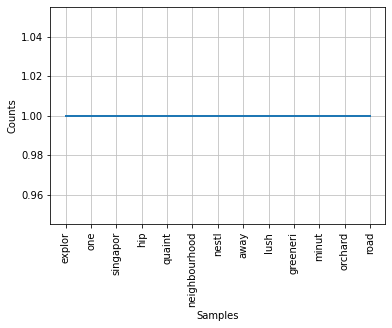

In [123]:
fdist = FreqDist(Singapore_Attraction_info['tokenized_word'].iloc[0])
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [31]:
from PIL import Image

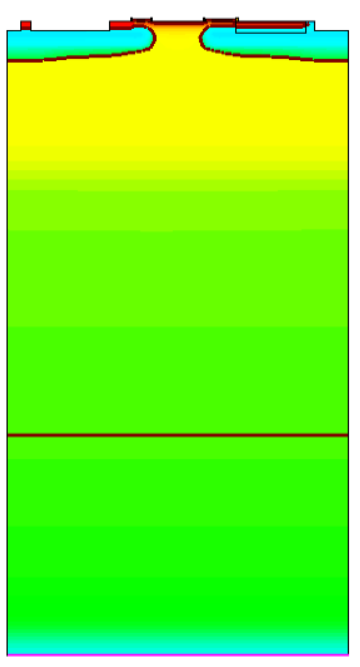

In [44]:
Image.open('1629291071094.png').convert("RGB")

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(360, 667)


ValueError: '#00ff9c' has no defined color name in css3

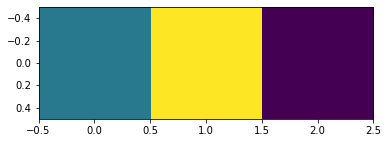

In [76]:
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from webcolors import rgb_to_name
##  picture
img = Image.open('1629291071094.png').convert("RGB")
##  to  array
data = asarray(Image.open('1629291071094.png').convert("RGB"))
print(data)
h,w =img.size 
print(img.size)
#plt.imshow(np.array(img.getpixel((1,1)), dtype=np.uint8).reshape((int(h),int(w),3)))
plt.imshow(np.expand_dims(img.getpixel((100,300)), axis=0))